# Source Counts

In [ ]:
flag  = pd.read_csv('')

# Feature details

In [39]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
print(x.columns.to_list())

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
['gal_b2', 'gal_l2', 'var_inter_prob_b', 'var_inter_sigma_b', 'var_intra_prob_b', 'var_inter_index_b', 'kp_intra_prob_b', 'var_intra_index_b', 'h-csc', 'b-csc', 'm-csc', 's-csc', 'u-csc', '0p3_8_csc', 'FUV', 'NUV', 'u-sdss', 'g-sdss', 'r-sdss', 'i-sdss', 'z-sdss', 'W1', 'W2', 'W3', 'W4', '24_microns_(MIPS)', 'J', 'H', 'K', 'G', 'Bp', 'Rp', 'B-R', 'G-J', 'G-W2', 'Bp-H', 'Bp-W3', 'Rp-K', 'J-H', 'J-W1', 'W1-W2']


In [3]:
x.columns.to_list()

['gal_b2',
 'gal_l2',
 'var_inter_prob_b',
 'var_inter_sigma_b',
 'var_intra_prob_b',
 'var_inter_index_b',
 'kp_intra_prob_b',
 'var_intra_index_b',
 'h-csc',
 'b-csc',
 'm-csc',
 's-csc',
 'u-csc',
 '0p3_8_csc',
 'FUV',
 'NUV',
 'u-sdss',
 'g-sdss',
 'r-sdss',
 'i-sdss',
 'z-sdss',
 'W1',
 'W2',
 'W3',
 'W4',
 '24_microns_(MIPS)',
 'J',
 'H',
 'K',
 'G',
 'Bp',
 'Rp',
 'B-R',
 'G-J',
 'G-W2',
 'Bp-H',
 'Bp-W3',
 'Rp-K',
 'J-H',
 'J-W1',
 'W1-W2']

In [12]:
deets(df , 1)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


# Imputation comparison

In [89]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
from IPython.display import display
from tqdm import tqdm_notebook
import tqdm
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import  IterativeImputer 
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.preprocessing import Normalizer
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="whitegrid")

%load_ext autoreload
%autoreload 2

In [102]:
from utilities import get_score
fname =  f'temp_res_comp/train_prob/mode_GB.csv'
df = pd.read_csv(fname)
temp = get_score([df] , k=10 , sc_average = 'macro')
d1 = temp['class_scores']

fname =  f'temp_res_comp/train_prob/10iter_rfimp_GB.csv'
df = pd.read_csv(fname)
temp = get_score([df] , k=10 , sc_average = 'macro')
d2 = temp['class_scores']

df = pd.concat([d1,d2] , axis=1 , names=['Mode' , 'Iterative Regression'] , levels= ['Mode' , 'Iterative Regression'])
df.to_csv('temp.csv' , float_format='%.2f')

# Gamma Tuning

In [77]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [78]:
import joblib 
gamma_tune_dict = joblib.load('../not_on_git/gamma_tune_dict.pkl')
gamma_tune_dict

{0.08: <__main__.make_model at 0x7fb275f74ba8>,
 0.09: <__main__.make_model at 0x7fb27d2dad30>,
 0.0: <__main__.make_model at 0x7fb2763c3940>,
 0.01: <__main__.make_model at 0x7fb276690c50>,
 0.02: <__main__.make_model at 0x7fb27c75a7f0>,
 0.03: <__main__.make_model at 0x7fb275f4b588>,
 0.04: <__main__.make_model at 0x7fb27d1a1588>,
 0.05: <__main__.make_model at 0x7fb27d795048>,
 0.06: <__main__.make_model at 0x7fb27d898e10>,
 0.07: <__main__.make_model at 0x7fb2767d2c88>,
 0.065: <__main__.make_model at 0x7fb276735eb8>,
 0.075: <__main__.make_model at 0x7fb2766cb198>,
 0.085: <__main__.make_model at 0x7fb27d8b5390>,
 0.0775: <__main__.make_model at 0x7fb27d1975f8>,
 0.0725: <__main__.make_model at 0x7fb276386be0>,
 0.1: <__main__.make_model at 0x7fb276664c88>,
 0.095: <__main__.make_model at 0x7fb27642c9e8>,
 0.0675: <__main__.make_model at 0x7fb27d8080f0>}

In [86]:

f1 , pres  , recall , mcc = []  , [] , [] , [] 
gamma = []
for el in gamma_tune_dict.keys():
    f1.append(gamma_tune_dict[el].result['f1'])
    pres.append(gamma_tune_dict[el].result['precision'])
    recall.append(gamma_tune_dict[el].result['recall'])
    mcc.append(gamma_tune_dict[el].result['mcc'])
    gamma.append(el)
gamma_score = pd.DataFrame({
    'gamma' : gamma ,
    'MCC' : mcc ,
    'precision' : pres , 
    'recall' : recall , 
    'f1 score' : f1 ,
}).sort_values(by='gamma').reset_index(drop=True)
gamma_score = gamma_score[gamma_score['gamma']<0.098]
gamma_score = gamma_score[gamma_score['gamma']!=0.0675]
#gamma_score =  gamma_score[gamma_score['gamma']>0.038]
gamma_score

gamma       MCC  precision    recall  f1 score
0   0.0000  0.902354   0.825647  0.741914  0.775135
1   0.0100  0.903654   0.815030  0.744892  0.772984
2   0.0200  0.904010   0.814175  0.750969  0.777873
3   0.0300  0.908147   0.827579  0.773332  0.797430
4   0.0400  0.907496   0.807328  0.764431  0.783577
5   0.0500  0.905469   0.806781  0.771818  0.787540
6   0.0600  0.906925   0.812620  0.790910  0.800966
7   0.0650  0.906818   0.806899  0.788814  0.796865
9   0.0700  0.904211   0.795280  0.783880  0.788864
10  0.0725  0.904418   0.796098  0.788023  0.790790
11  0.0750  0.906057   0.800935  0.794440  0.796469
12  0.0775  0.903385   0.801790  0.788546  0.793449
13  0.0800  0.903595   0.795149  0.792761  0.792500
14  0.0850  0.904120   0.797221  0.791712  0.793079
15  0.0900  0.895269   0.783244  0.785888  0.783295
16  0.0950  0.888571   0.774680  0.778999  0.774563

In [92]:
gamma_score.iloc[[3 , 6,10]]

gamma       MCC  precision    recall  f1 score
3   0.030  0.908147   0.827579  0.773332  0.797430
6   0.060  0.906925   0.812620  0.790910  0.800966
11  0.075  0.906057   0.800935  0.794440  0.796469

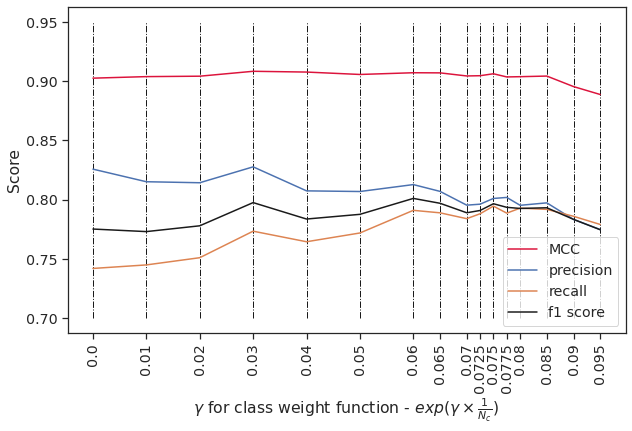

In [87]:
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="ticks")
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(10,6))

ax.plot(gamma_score['gamma'] , gamma_score['MCC'] , label = 'MCC' , color='crimson')
ax.plot(gamma_score['gamma'] , gamma_score['precision'] , label = 'precision')
ax.plot(gamma_score['gamma'] , gamma_score['recall'] , label = 'recall') 
ax.plot(gamma_score['gamma'] , gamma_score['f1 score'] , label = 'f1 score' , color='k') 
ax.set_xticks(gamma_score['gamma'] , )
ax.set_xticklabels(gamma_score['gamma'], rotation=90)
ax.vlines(gamma_score['gamma'] , ymin = 0.7 , ymax=0.95 , linewidth=1 , color='k' , alpha=1, linestyle='-.')

#ax2 = ax.twinx()
ax.grid(False)
ax.set_xlabel(r'$\gamma$ for class weight function - $exp(\gamma\times\frac{1}{N_c} )$')
ax.set_ylabel('Score')
plt.legend()
plt.savefig('final_plots/gamma_tuning_02.jpg')
plt.show()

> TODO : model tuning for 0.06, and reerification

In [122]:
gamma_tune_dict[0.07].result

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2769
 AGN           2416
 YSO           1177
 HMXB           740
 ULX            210
 CV             157
 LMXB           122
 PULSAR         112,
 'balanced_accuracy': 0.7990135039182039,
 'accuracy': 0.9347007659353499,
 'precision': 0.8132076064780758,
 'recall': 0.7990135039182039,
 'f1': 0.805187821761211,
 'mcc': 0.911602433539088,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.974113         0.965646  0.969861
 CV          0.584337         0.617834  0.600619
 HMXB        0.913102         0.922973  0.918011
 LMXB        0.804196         0.942623  0.867925
 PULSAR      0.485149         0.437500  0.460094
 STAR        0.957348         0.964608  0.960964
 ULX         0.715640         0.719048  0.717340
 YSO         0.958225         0.935429  0.946690,
 'res

# Calculate scores

In [140]:
import pandas as pd 
import numpy as np 
from utilities import get_score

In [141]:
df = pd.read_csv('temp_res_comp/train_prob/mode_GB.csv' , index_col='name')
#df = pd.read_csv('temp_res_comp/train_prob/mode_RF.csv' , index_col='name')
#df = pd.read_csv('temp_res_comp/train_prob/none_lightGBM.csv' , index_col='name')
df 

true_class pred_class  pred_prob  prob_AGN   prob_CV  \
name                                                                         
2CXO J181044.4-260901         CV     PULSAR   0.494503  0.013341  0.393068   
2CXO J104409.2-595904        YSO        YSO   0.781595  0.007102  0.032291   
2CXO J224731.7+033549        AGN     PULSAR   0.360628  0.261291  0.057642   
2CXO J053536.6-051850       STAR       STAR   0.909449  0.005718  0.039022   
2CXO J201657.8-704703        ULX     PULSAR   0.479177  0.017152  0.394054   
...                          ...        ...        ...       ...       ...   
2CXO J123613.4+275150        AGN        AGN   0.899162  0.899162  0.039616   
2CXO J161436.5-223031     PULSAR     PULSAR   0.458746  0.005546  0.439247   
2CXO J004142.9-091915       STAR       STAR   0.982564  0.005121  0.001937   
2CXO J040148.9-054056        AGN        AGN   0.977999  0.977999  0.004298   
2CXO J145528.6+031300        AGN        AGN   0.956527  0.956527  0.010662   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J181044.4-260901   0.016631   0.007113     0.494503   0.044733  0.011582   
2CXO J104409.2-595904   0.030874   0.011654     0.031463   0.087751  0.017270   
2CXO J224731.7+033549   0.112283   0.009154     0.360628   0.028470  0.101648   
2CXO J053536.6-051850   0.015799   0.010959     0.012286   0.909449  0.004848   
2CXO J201657.8-704703   0.060770   0.014311     0.479177   0.016743  0.011379   
...                          ...        ...          ...        ...       ...   
2CXO J123613.4+275150   0.005901   0.001148     0.001685   0.003309  0.048364   
2CXO J161436.5-223031   0.018749   0.011930     0.458746   0.006238  0.055581   
2CXO J004142.9-091915   0.008805   0.000297     0.000010   0.982564  0.001242   
2CXO J040148.9-054056   0.003097   0.000158     0.000970   0.008383  0.004967   
2CXO J145528.6+031300   0.028022   0.000182     0.000859   0.000358  0.003230   

                       prob_YSO  
name                             
2CXO J181044.4-260901  0.019030  
2CXO J104409.2-595904  0.781595  
2CXO J224731.7+033549  0.068883  
2CXO J053536.6-051850  0.001918  
2CXO J201657.8-704703  0.006413  
...                         ...  
2CXO J123613.4+275150  0.000816  
2CXO J161436.5-223031  0.003963  
2CXO J004142.9-091915  0.000024  
2CXO J040148.9-054056  0.000128  
2CXO J145528.6+031300  0.000159  

[7703 rows x 11 columns]

In [142]:
get_score([df] , sc_average='macro')

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2633
 AGN           2184
 YSO           1182
 HMXB           786
 ULX            338
 CV             239
 PULSAR         196
 LMXB           145,
 'avg_scores': {'balanced_accuracy': 0.7951883707695815,
  'accuracy': 0.8908217577567181,
  'precision': 0.7099381876425648,
  'recall': 0.7951883707695815,
  'f1': 0.7404955122619998},
 'mcc': 0.8560587678459877,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.892693         0.978938  0.933828
 CV          0.620482         0.430962  0.508642
 HMXB        0.875668         0.833333  0.853977
 LMXB        0.804196         0.793103  0.798611
 PULSAR      0.554455         0.285714  0.377104
 STAR        0.915771         0.970376  0.942283
 ULX         0.758294         0.473373  0.582878
 YSO         0.939948         0.9

In [143]:
get_score([df] , sc_average='micro')

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2633
 AGN           2184
 YSO           1182
 HMXB           786
 ULX            338
 CV             239
 PULSAR         196
 LMXB           145,
 'avg_scores': {'balanced_accuracy': 0.7951883707695815,
  'accuracy': 0.8908217577567181,
  'precision': 0.8908217577567181,
  'recall': 0.8908217577567181,
  'f1': 0.8908217577567182},
 'mcc': 0.8560587678459877,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.892693         0.978938  0.933828
 CV          0.620482         0.430962  0.508642
 HMXB        0.875668         0.833333  0.853977
 LMXB        0.804196         0.793103  0.798611
 PULSAR      0.554455         0.285714  0.377104
 STAR        0.915771         0.970376  0.942283
 ULX         0.758294         0.473373  0.582878
 YSO         0.939948         0.9

# Feature Feature Correlation

# Missing features

In [13]:
import pandas as pd 
from matplotlib import pyplot as plt 

In [14]:
from utilities import deets 
from choices import param_dict

In [15]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [16]:
x_all = x.copy()
x_all.insert(0 , 'class' , y.to_list())
x_all

class    gal_b2    gal_l2  ...       J-H      J-W1     W1-W2
name                                             ...                              
2CXO J002359.4-720438    CV  2.487849  8.497420  ...       NaN       NaN       NaN
2CXO J174041.4-534004    CV  4.327881  9.393618  ...       NaN       NaN       NaN
2CXO J002409.2-720543    CV  2.488746  8.496825  ...       NaN       NaN       NaN
2CXO J002411.1-720620    CV  2.489281  8.496673  ...       NaN       NaN       NaN
2CXO J002401.4-720441    CV  2.487878  8.497314  ...       NaN       NaN       NaN
...                     ...       ...       ...  ...       ...       ...       ...
2CXO J003444.5-431554   AGN  0.888957  8.713766  ...       NaN       NaN       NaN
2CXO J203606.3+422737   YSO  5.054270  2.262789  ...  5.048179       NaN       NaN
2CXO J131747.5+411745   AGN  9.176328  2.880393  ...       NaN       NaN  6.731328
2CXO J023234.3-073105   AGN  1.697797  4.953135  ...  3.135379  5.458946  6.790977
2CXO J103357.8+574942   AGN  7.844756  4.207243  ...       NaN       NaN       NaN

[7703 rows x 42 columns]

In [17]:
miss = []
for cl in y.unique():
#    cl = 'AGN'
    temp = x_all[x_all['class']==cl].drop(columns=['class'])
    miss.append((1-temp.isna().sum(axis=0) / len(temp)).to_frame(name=cl))
miss = pd.concat(miss , axis=1)
miss.insert(0 , 'overall' , (1-x.isna().sum(axis=0) / len(x)).to_list())
miss = miss[['overall' , 'AGN' , 'STAR' ,'YSO' , 'CV' , 'HMXB' , 'PULSAR'  , 'LMXB' ,'ULX']]

In [18]:
from choices import param_dict 
param_dict['inter-obs-var'] = ['var_inter_prob_b' , 'var_inter_sigma_b' , 'var_inter_index_b']
param_dict['intra-obs-var'] = ['var_intra_prob_b' , 'kp_intra_prob_b' , 'var_intra_index_b']
comb = ['WISE' , '2MASS' , 'GAIA' , 'SDSS' , 'GALEX' ,'inter-obs-var','intra-obs-var' ]
comb_df = []
for c in comb:
    comb_df.append(miss.loc[param_dict[c]].mean().to_frame(name=c).T)
comb_df = pd.concat(comb_df)
comb_df

overall       AGN      STAR  ...    PULSAR      LMXB       ULX
WISE           0.412307  0.768163  0.365591  ...  0.049505  0.076923  0.014218
2MASS          0.553507  0.263744  0.913262  ...  0.089109  0.048951  0.030016
GAIA           0.599766  0.605428  0.800358  ...  0.287129  0.181818  0.123223
SDSS           0.237648  0.705136  0.037419  ...  0.000000  0.000000  0.048341
GALEX          0.171881  0.492902  0.044624  ...  0.019802  0.034965  0.009479
inter-obs-var  0.496560  0.317745  0.547312  ...  0.495050  0.951049  0.464455
intra-obs-var  0.948851  0.986639  0.922222  ...  0.950495  0.874126  0.990521

[7 rows x 9 columns]

In [19]:
sep_col = ['h-csc' ,'b-csc' , 'm-csc' , 'u-csc' ,'0p3_8_csc' ,'B-R' , 'G-J' , 'G-W2' , 'Bp-H' , 'Bp-W3' , 'Rp-K' , 'J-H' , 'J-W1' , 'W1-W2' , '24_microns_(MIPS)']
sep_df = miss.loc[sep_col]
sep_df

overall       AGN      STAR  ...    PULSAR      LMXB       ULX
h-csc              0.742568  0.774113  0.717563  ...  0.663366  0.923077  0.819905
b-csc              0.984811  0.993319  0.970609  ...  0.990099  0.986014  0.995261
m-csc              0.951707  0.972860  0.949462  ...  0.930693  0.888112  0.985782
u-csc              0.956900  0.985386  0.907168  ...  0.940594  0.986014  0.976303
0p3_8_csc          0.829417  0.850939  0.828315  ...  0.831683  0.601399  0.867299
B-R                0.599766  0.605428  0.800358  ...  0.287129  0.181818  0.123223
G-J                0.425159  0.209603  0.746595  ...  0.069307  0.034965  0.014218
G-W2               0.283786  0.531106  0.263799  ...  0.039604  0.048951  0.014218
Bp-H               0.425159  0.209603  0.746595  ...  0.069307  0.034965  0.014218
Bp-W3              0.284305  0.532359  0.264516  ...  0.039604  0.048951  0.014218
Rp-K               0.427626  0.217119  0.746595  ...  0.069307  0.034965  0.018957
J-H                0.548488  0.248017  0.913262  ...  0.089109  0.048951  0.028436
J-W1               0.237829  0.235073  0.354122  ...  0.029703  0.041958  0.004739
W1-W2              0.410879  0.764509  0.364516  ...  0.049505  0.076923  0.014218
24_microns_(MIPS)  0.433208  0.404175  0.524014  ...  0.029703  0.062937  0.104265

[15 rows x 9 columns]

In [20]:
miss_comb_df = pd.concat([sep_df , comb_df]).sort_values(by='overall' , ascending=False)
miss_comb_df

overall       AGN      STAR  ...    PULSAR      LMXB       ULX
b-csc              0.984811  0.993319  0.970609  ...  0.990099  0.986014  0.995261
u-csc              0.956900  0.985386  0.907168  ...  0.940594  0.986014  0.976303
m-csc              0.951707  0.972860  0.949462  ...  0.930693  0.888112  0.985782
intra-obs-var      0.948851  0.986639  0.922222  ...  0.950495  0.874126  0.990521
0p3_8_csc          0.829417  0.850939  0.828315  ...  0.831683  0.601399  0.867299
h-csc              0.742568  0.774113  0.717563  ...  0.663366  0.923077  0.819905
B-R                0.599766  0.605428  0.800358  ...  0.287129  0.181818  0.123223
GAIA               0.599766  0.605428  0.800358  ...  0.287129  0.181818  0.123223
2MASS              0.553507  0.263744  0.913262  ...  0.089109  0.048951  0.030016
J-H                0.548488  0.248017  0.913262  ...  0.089109  0.048951  0.028436
inter-obs-var      0.496560  0.317745  0.547312  ...  0.495050  0.951049  0.464455
24_microns_(MIPS)  0.433208  0.404175  0.524014  ...  0.029703  0.062937  0.104265
Rp-K               0.427626  0.217119  0.746595  ...  0.069307  0.034965  0.018957
G-J                0.425159  0.209603  0.746595  ...  0.069307  0.034965  0.014218
Bp-H               0.425159  0.209603  0.746595  ...  0.069307  0.034965  0.014218
WISE               0.412307  0.768163  0.365591  ...  0.049505  0.076923  0.014218
W1-W2              0.410879  0.764509  0.364516  ...  0.049505  0.076923  0.014218
Bp-W3              0.284305  0.532359  0.264516  ...  0.039604  0.048951  0.014218
G-W2               0.283786  0.531106  0.263799  ...  0.039604  0.048951  0.014218
J-W1               0.237829  0.235073  0.354122  ...  0.029703  0.041958  0.004739
SDSS               0.237648  0.705136  0.037419  ...  0.000000  0.000000  0.048341
GALEX              0.171881  0.492902  0.044624  ...  0.019802  0.034965  0.009479

[22 rows x 9 columns]

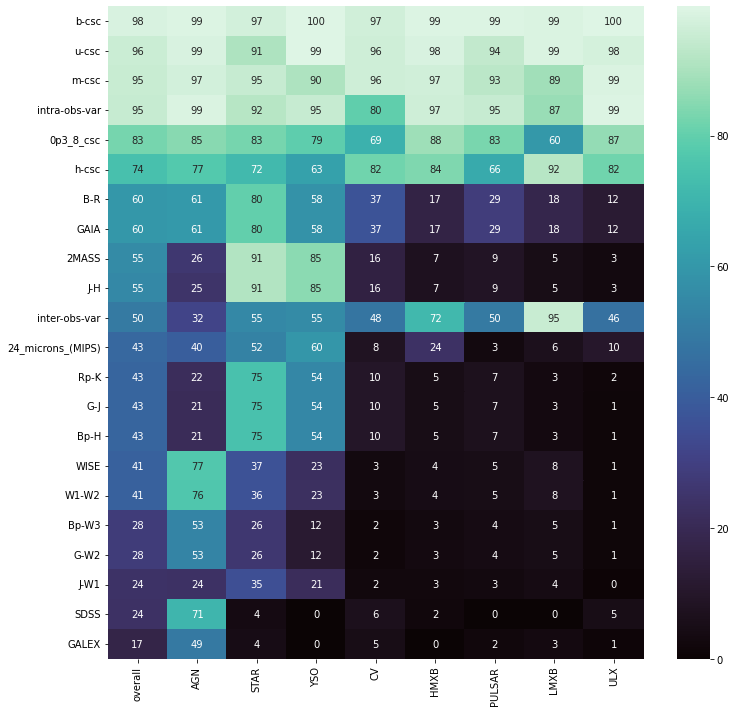

In [22]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(miss_comb_df*100 , ax=ax , annot=True , fmt='.0f' , cmap='mako')
plt.xticks(rotation=90)
#plt.savefig('final_plots/missing_features.eps' , format='eps')
plt.savefig('final_plots/missing_features.jpg' , format='jpg')
plt.show()

In [43]:
print(miss.to_latex(float_format="%.2f" , longtable=False))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   CV &  STAR &  HMXB &  YSO &  ULX &  AGN &  LMXB &  PULSAR \\
\midrule
gal\_b2            & 0.00 &  0.00 &  0.00 & 0.00 & 0.00 & 0.00 &  0.00 &    0.00 \\
gal\_l2            & 0.00 &  0.00 &  0.00 & 0.00 & 0.00 & 0.00 &  0.00 &    0.00 \\
var\_inter\_prob\_b  & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
var\_inter\_sigma\_b & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
var\_intra\_prob\_b  & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
var\_inter\_index\_b & 0.52 &  0.45 &  0.28 & 0.45 & 0.54 & 0.68 &  0.05 &    0.50 \\
kp\_intra\_prob\_b   & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
var\_intra\_index\_b & 0.20 &  0.08 &  0.03 & 0.05 & 0.01 & 0.01 &  0.13 &    0.05 \\
h-csc             & 0.18 &  0.28 &  0.16 & 0.37 & 0.18 & 0.23 &  0.08 &    0.34 \\
b-csc             & 0.03 &  0.03 &  0.01 & 0.00 & 0.00 & 0.01 &  0.01 &    0.01 \\
m-csc             & 0.04 &  0.05 &  0

In [24]:
miss = []
for cl in y.unique():
    temp = x_all[x_all['class']==cl].drop(columns=['class'])
    x_all.isna().sum(axis=0) / len(x_all).to_df()

gal_b2               0.000000
gal_l2               0.000000
var_inter_prob_b     0.503440
var_inter_sigma_b    0.503440
var_intra_prob_b     0.051149
var_inter_index_b    0.503440
kp_intra_prob_b      0.051149
var_intra_index_b    0.051149
h-csc                0.257432
b-csc                0.015189
m-csc                0.048293
s-csc                0.037128
u-csc                0.043100
0p3_8_csc            0.170583
FUV                  0.829287
NUV                  0.826951
u-sdss               0.765027
g-sdss               0.755420
r-sdss               0.763469
i-sdss               0.763209
z-sdss               0.764637
W1                   0.589121
W2                   0.588732
W3                   0.588212
W4                   0.584707
24_microns_(MIPS)    0.566792
J                    0.451383
H                    0.451512
K                    0.436583
G                    0.400234
Bp                   0.400234
Rp                   0.400234
B-R                  0.400234
G-J       

# Hyper Parameter Tuning

In [3]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [4]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight


In [5]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    print('>>>TIRAL')
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [40, 50,70,80, 100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.2, 0.95, step=0.1
        # ),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.2, 0.95, step=0.1
        # ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        cl_weight = calc_weight(0.07 , y)
        model = lgbm.LGBMClassifier(class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , num_class=len(np.unique(y)) ,**param_grid)
        print('-----MODEL-------')
        print(model)
        print('------------------')
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="softmax",
            early_stopping_rounds=100,
            verbose=0
        )
        preds = model.predict_proba(X_test)
        #print(preds)
        #cv_scores[idx] = preds
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [6]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, x, y)
study.optimize(func, n_trials=20)

[I 2022-05-08 02:15:42,602] A new study created in memory with name: LGBM Classifier
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.08435810003393353,
               max_depth=10, metric=['auc_mu'], n_estimators=50, num_class=8,
               num_leaves=1920, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:16:45,236] Trial 0 finished with value: 0.2728934983808601 and parameters: {'n_estimators': 50, 'learning_rate': 0.08435810003393353, 'num_leaves': 1920, 'max_depth': 10}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.26484875700267746,
               max_depth=7, metric=['auc_mu'], n_estimators=40, num_class=8,
               num_leaves=1720, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:17:05,455] Trial 1 finished with value: 0.3092579568142292 and parameters: {'n_estimators': 40, 'learning_rate': 0.26484875700267746, 'num_leaves': 1720, 'max_depth': 7}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.20546346076682379,
               max_depth=5, metric=['auc_mu'], n_estimators=70, num_class=8,
               num_leaves=20, objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with pos

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2022-05-08 02:17:21,613] Trial 2 finished with value: 0.293319289647648 and parameters: {'n_estimators': 70, 'learning_rate': 0.20546346076682379, 'num_leaves': 20, 'max_depth': 5}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.21634960669965786,
               max_depth=12, metric=['auc_mu'], n_estimators=70, num_class=8,
               num_leaves=2220, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:18:35,506] Trial 3 finished with value: 0.29904015423442054 and parameters: {'n_estimators': 70, 'learning_rate': 0.21634960669965786, 'num_leaves': 2220, 'max_depth': 12}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.11330550801373894,
               max_depth=11, metric=['auc_mu'], num_class=8, num_leaves=1320,
               objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:20:13,132] Trial 4 finished with value: 0.28075068534637293 and parameters: {'n_estimators': 100, 'learning_rate': 0.11330550801373894, 'num_leaves': 1320, 'max_depth': 11}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.2131973970924132,
               max_depth=11, metric=['auc_mu'], n_estimators=40, num_class=8,
               num_leaves=2120, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:21:04,121] Trial 5 finished with value: 0.2943276167966497 and parameters: {'n_estimators': 40, 'learning_rate': 0.2131973970924132, 'num_leaves': 2120, 'max_depth': 11}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.06174622827511079,
               max_depth=5, metric=['auc_mu'], n_estimators=70, num_class=8,
               num_leaves=20, objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2022-05-08 02:21:20,565] Trial 6 finished with value: 0.3260749114802751 and parameters: {'n_estimators': 70, 'learning_rate': 0.06174622827511079, 'num_leaves': 20, 'max_depth': 5}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.1210181143093592, max_depth=4,
               metric=['auc_mu'], n_estimators=40, num_class=8, num_leaves=1520,
               objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:21:28,809] Trial 7 finished with value: 0.3636306456621209 and parameters: {'n_estimators': 40, 'learning_rate': 0.1210181143093592, 'num_leaves': 1520, 'max_depth': 4}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.2202807391538881,
               max_depth=10, metric=['auc_mu'], num_class=8, num_leaves=2920,
               objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:22:24,418] Trial 8 finished with value: 0.2927184705801945 and parameters: {'n_estimators': 100, 'learning_rate': 0.2202807391538881, 'num_leaves': 2920, 'max_depth': 10}. Best is trial 0 with value: 0.2728934983808601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 

/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:23:27,416] Trial 9 finished with value: 0.2876330784890157 and parameters: {'n_estimators': 100, 'learning_rate': 0.18328780050940865, 'num_leaves': 2720, 'max_depth': 10}. Best is trial 0 with value: 0.2728934983808601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.01658329475009357,
               max_depth=8, metric=['auc_mu'], n_estimators=50, num_class=8,
               num_leaves=920, objective='multiclass', sparse=True,
               verbosity=0)
------------------


/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:23:59,099] Trial 10 finished with value: 0.7657269269345264 and parameters: {'n_estimators': 50, 'learning_rate': 0.01658329475009357, 'num_leaves': 920, 'max_depth': 8}. Best is trial 0 with value: 0.2728934983808601.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.11186452530943586,
               max_depth=9, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=920, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:24:57,618] Trial 11 finished with value: 0.27246131174898347 and parameters: {'n_estimators': 80, 'learning_rate': 0.11186452530943586, 'num_leaves': 920, 'max_depth': 9}. Best is trial 11 with value: 0.27246131174898347.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
>>>TIRAL


/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.08359967779049024,
               max_depth=8, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=720, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:25:47,929] Trial 12 finished with value: 0.2694070289408567 and parameters: {'n_estimators': 80, 'learning_rate': 0.08359967779049024, 'num_leaves': 720, 'max_depth': 8}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.14569265658477104,
               max_depth=8, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=720, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:26:35,030] Trial 13 finished with value: 0.28261503292965884 and parameters: {'n_estimators': 80, 'learning_rate': 0.14569265658477104, 'num_leaves': 720, 'max_depth': 8}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.04700023273350605,
               max_depth=7, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=620, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:27:16,273] Trial 14 finished with value: 0.29045792142972543 and parameters: {'n_estimators': 80, 'learning_rate': 0.04700023273350605, 'num_leaves': 620, 'max_depth': 7}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.1084246158977403, max_depth=9,
               metric=['auc_mu'], n_estimators=80, num_class=8, num_leaves=1020,
               objective='multiclass', sparse=True, verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:28:13,028] Trial 15 finished with value: 0.2702334808875583 and parameters: {'n_estimators': 80, 'learning_rate': 0.1084246158977403, 'num_leaves': 1020, 'max_depth': 9}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.16222750075941103,
               max_depth=6, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=420, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:28:41,119] Trial 16 finished with value: 0.2827617250268227 and parameters: {'n_estimators': 80, 'learning_rate': 0.16222750075941103, 'num_leaves': 420, 'max_depth': 6}. Best is trial 12 with value: 0.2694070289408567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.07625204269649177,
               max_depth=9, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=1220, objective='multiclass', sparse=True,
               verbosity=0)
------------------


/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:29:39,795] Trial 17 finished with value: 0.2731796622747429 and parameters: {'n_estimators': 80, 'learning_rate': 0.07625204269649177, 'num_leaves': 1220, 'max_depth': 9}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.01944006859684841,
               max_depth=3, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=420, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2022-05-08 02:29:50,641] Trial 18 finished with value: 0.7874251935333871 and parameters: {'n_estimators': 80, 'learning_rate': 0.01944006859684841, 'num_leaves': 420, 'max_depth': 3}. Best is trial 12 with value: 0.2694070289408567.
/home/kumaran/.local/lib/python3.6/site-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [20, 3000] and step=100, but the range is not divisible by `step`. It will be replaced by [20, 2920].

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



>>>TIRAL
-----MODEL-------
LGBMClassifier(class_weight={'AGN': 1.2524978967563674,
                             'CV': 25.745323836808723,
                             'HMXB': 2.0562192560551287,
                             'LMXB': 43.41041115489145,
                             'PULSAR': 208.24450024014098,
                             'STAR': 1.2132045326966958,
                             'ULX': 12.87770640060345,
                             'YSO': 1.5988527422270495},
               is_unbalance=True, learning_rate=0.29074000898894325,
               max_depth=6, metric=['auc_mu'], n_estimators=80, num_class=8,
               num_leaves=1120, objective='multiclass', sparse=True,
               verbosity=0)
------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-05-08 02:30:17,392] Trial 19 finished with value: 0.33811212432328774 and parameters: {'n_estimators': 80, 'learning_rate': 0.29074000898894325, 'num_leaves': 1120, 'max_depth': 6}. Best is trial 12 with value: 0.2694070289408567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [7]:

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.26941
	Best params:
		n_estimators: 80
		learning_rate: 0.08359967779049024
		num_leaves: 720
		max_depth: 8


# Hyper Parameter tuning : Marginal

In [40]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd 
import numpy as np 
from utilities import deets 
from choices import param_dict
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [11]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [13]:
import lightgbm as lgb 
import joblib

### n_estimators

In [24]:
try:
    n_est_tune = joblib.load('../not_on_git/n_est_tune_dict.pkl')
except:
    n_est_tune = {}

In [ ]:
    
for n in [800 , 1000]:
    gamma = 0.07
    cl_weight = calc_weight(gamma , y)
    clf = lgb.LGBMClassifier(n_estimators=n ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
    model = make_model('lightGBM' , clf ,gamma , x,y)
    model.validate()
    n_est_tune[n] = {
        'avg_scores' : model.result['avg_scores'] ,
        'class_scores' : model.result['class_scores']
    }
    joblib.dump(n_est_tune , '../not_on_git/n_est_tune_dict.pkl' , compress=3)


In [33]:
n_est_tune[1000]

{'avg_scores': {'balanced_accuracy': 0.7834214647032423,
  'accuracy': 0.9341814877320525,
  'precision': 0.820823260161457,
  'recall': 0.7834214647032423,
  'f1': 0.800531040446295},
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.978706         0.965801  0.972211
 CV          0.548193         0.619048  0.581470
 HMXB        0.917112         0.911023  0.914057
 LMXB        0.811189         0.943089  0.872180
 PULSAR      0.425743         0.505882  0.462366
 STAR        0.957348         0.960446  0.958894
 ULX         0.668246         0.738220  0.701493
 YSO         0.960836         0.923077  0.941578}

In [38]:
n_est_tune.keys()

dict_keys([50, 100, 200, 300, 400, 500, 600, 800])

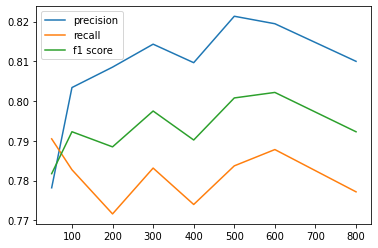

In [39]:
a , p ,r ,f ,m = [], [] , [], [] , []
for n in n_est_tune.values():
    a.append(n['avg_scores']['accuracy'])
    p.append(n['avg_scores']['precision'])
    r.append(n['avg_scores']['recall'])
    f.append(n['avg_scores']['f1'])
    #m.append(n['mcc'])
plt.plot(n_est_tune.keys() , p , label='precision')
plt.plot(n_est_tune.keys() , r , label='recall')
plt.plot(n_est_tune.keys() , f , label='f1 score')
#plt.plot(n_est_tune.keys() , m , label='MCC')
#plt.plot(n_est_tune.keys() , a , label='')
plt.legend()
plt.show()

### Learning Rate

In [41]:
try:
    lr_tune = joblib.load('../not_on_git/lr_tune_dict.pkl')
except:
    lr_tune = {}

In [ ]:
    
for n in [0.01 , 0.05 , 0.1 , 0.15 , 0.20 , 0.25 , 0.30]:
    gamma = 0.07
    cl_weight = calc_weight(gamma , y)
    clf = lgb.LGBMClassifier(n_estimators=80 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True , learning_rate = n)
    model = make_model('lightGBM' , clf ,gamma , x,y)
    model.validate(k=5)
    lr_tune[n] = {
        'avg_scores' : model.result['avg_scores'] ,
        'class_scores' : model.result['class_scores']
    }
    joblib.dump(n_est_tune , '../not_on_git/lr_tune_dict.pkl' , compress=3)


In [52]:
lr_tune[0.25]

{'avg_scores': {'balanced_accuracy': 0.7689957001688149,
  'accuracy': 0.9289887056990783,
  'precision': 0.8059085027346792,
  'recall': 0.7689957001688149,
  'f1': 0.7857888964081075},
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.976200         0.962536  0.969320
 CV          0.560241         0.632653  0.594249
 HMXB        0.897059         0.906757  0.901882
 LMXB        0.776224         0.940678  0.850575
 PULSAR      0.366337         0.425287  0.393617
 STAR        0.955914         0.956943  0.956428
 ULX         0.663507         0.703518  0.682927
 YSO         0.956484         0.918896  0.937313}

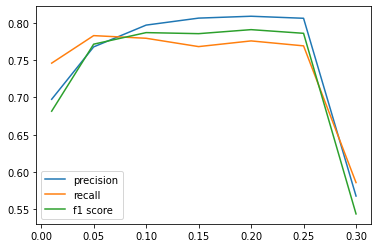

In [51]:
a , p ,r ,f ,m = [], [] , [], [] , []
for n in lr_tune.values():
    a.append(n['avg_scores']['accuracy'])
    p.append(n['avg_scores']['precision'])
    r.append(n['avg_scores']['recall'])
    f.append(n['avg_scores']['f1'])
    #m.append(n['avg_scores']['mcc'])
plt.plot(lr_tune.keys() , p , label='precision')
plt.plot(lr_tune.keys() , r , label='recall')
plt.plot(lr_tune.keys() , f , label='f1 score')
#plt.plot(lr_tune.keys() , m , label='MCC')
#plt.plot(lr_tune.keys() , a , label='')
plt.legend()
plt.show()

# Source Variability

In [53]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


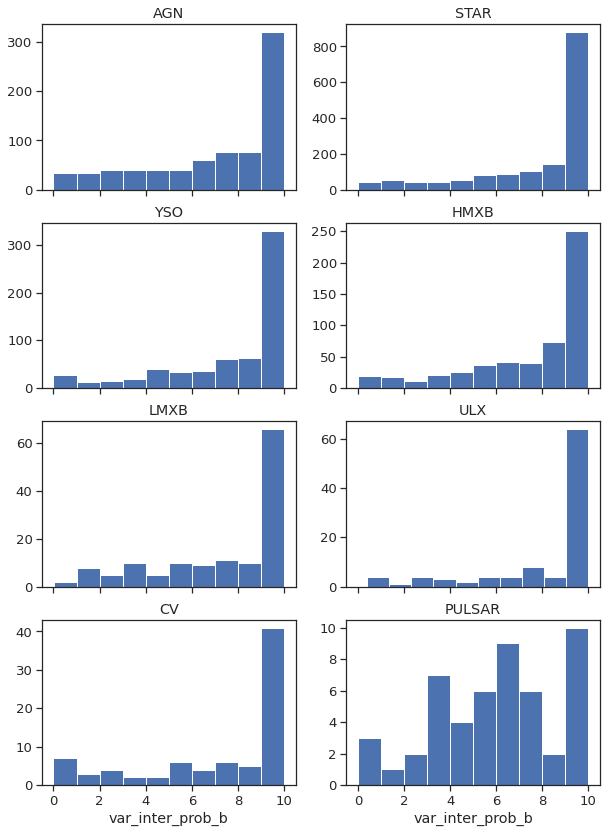

In [86]:
cl = ['AGN' ,'STAR' , 'YSO' , 'HMXB' , 'LMXB' , 'ULX' ,'CV' ,'PULSAR']
sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
f = 'kp_intra_prob_b'
f = 'var_inter_prob_b'
fig , ax = plt.subplots(nrows=4, ncols=2 , figsize=(10,14) , sharex=True)
#plt.hist(x['kp_intra_prob_b'])
cl = np.reshape(cl , ax.shape)
for i in range(4):
    for j in range(2):
        temp = x[y==cl[i][j]]
        ax[i][j].hist(temp[f] , label = cl[i][j])
        ax[i][j].set_title(cl[i][j])
        #ax[i][j].legend()
        #ax[i][j].set_xlabel('var_intra_prob_b')
ax[3][0].set_xlabel(f)
ax[3][1].set_xlabel(f)

plt.show()

# Application on Globular Cluster sources

### Find globular cluster source names

### Imports

In [1]:
# Basic numeric and plotting imports

import numpy as np
import scipy

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors


import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astroquery.vizier import Vizier

import pyvo as vo

from ciao_contrib.runtool import search_csc
from sherpa.astro import ui

ModuleNotFoundError: No module named 'ciao_contrib'

In [46]:
import joblib
from matplotlib import pyplot as plt 
import seaborn as sns 
import numpy as np 
from utilities import make_model
import pandas as pd 

### Cone Search GC

In [12]:
gc = pd.read_csv('temp_files/gc_cat.csv')[['ID' , 'RA(2000)' , 'DEC']]
gc 

ID       RA(2000)           DEC
0       NGC-104  00 24 05.67     -72 04 52.6
1       NGC-288   00 52 45.24    -26 34 57.4
2       NGC-362    01 03 14.26  -70 50 55.6 
3     Whiting_1       02 02 57     -03 15 10
4       NG_1261    03 12 16.21   -55 12 58.4
..          ...            ...           ...
152    NGC-7089    21 33 27.02   -00 49 23.7
153    NGC-7099    21 40 22.12   -23 10 47.5
154      Pal-12    21 46 38.84   -21 15 09.4
155      Pal-13    23 06 44.44   +12 46 19.2
156    NGC-7492    23 08 26.63   -15 36 41.4

[157 rows x 3 columns]

In [13]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

In [14]:
help(cone.search)

Help on method search in module pyvo.dal.scs:

search(pos, radius=1.0, verbosity=2, **keywords) method of pyvo.dal.scs.SCSService instance
    submit a simple Cone Search query that requests objects or observations
    whose positions fall within some distance from a search position.
    
    Parameters
    ----------
    pos : astropy.coordinates.SkyCoord
        a SkyCoord instance defining the position of the center of the
        circular search region.
        converted if it's a iterable containing scalars,
        assuming icrs degrees.
    radius : `~astropy.units.Quantity` or float
        a Quantity instance defining the radius of the circular search
        region, in degrees.
        converted if it is another unit.
    verbosity : int
       an integer value that indicates the volume of columns
       to return in the result table.  0 means the minimum
       set of columns, 3 means as many columns as are available.
    **keywords :
       additional case insensitive param

In [16]:
gc[['RA(2000)' , 'DEC']]

RA(2000)           DEC
0    00 24 05.67     -72 04 52.6
1     00 52 45.24    -26 34 57.4
2      01 03 14.26  -70 50 55.6 
3         02 02 57     -03 15 10
4      03 12 16.21   -55 12 58.4
..             ...           ...
152    21 33 27.02   -00 49 23.7
153    21 40 22.12   -23 10 47.5
154    21 46 38.84   -21 15 09.4
155    23 06 44.44   +12 46 19.2
156    23 08 26.63   -15 36 41.4

[157 rows x 2 columns]

In [24]:
from astropy.coordinates import ICRS, Galactic, FK4, FK5
coords = ["1:12:43.2 +31:12:43", "1 12 43.2 +31 12 43"]
coords = [f'{r} {d}' for r,d in zip(gc['RA(2000)'] ,  gc['DEC'])]
coords = SkyCoord(coords, frame=FK4, unit=(u.hourangle, u.deg),)

In [37]:
from tqdm import tqdm 
maxrad = 30*u.arcmin
try:
    gc_obj = joblib.load('../not_on_git/gc_objects.pkl')
except:
    gc_obj = {}
for i in tqdm(range(len(gc))[:]):
    try:
        results = cone.search(pos=c[i], radius=maxrad, verbosity=3)
        temp = results.to_table().to_pandas()[['name' ,'ra' ,'dec' , 'err_ellipse_r0' , 'err_ellipse_r1' , 'err_ellipse_ang' , 'gal_b' , 'gal_l']]
        temp = temp.drop_duplicates('name')
        temp.insert(0 , 'gc' , gc['ID'][i])
        gc_obj[gc['ID'][i]] = temp 
        joblib.dump(gc_obj , '../not_on_git/gc_objects.pkl' , compress=3)
    except:
        print(f">> [ERROR]{gc['ID'][i]} could not be done due to some reason")


  2%|▏         | 3/157 [00:16<10:01,  3.91s/it]

>> [ERROR] NGC-362 could not be done due to some reason


  4%|▍         | 6/157 [00:19<04:11,  1.67s/it]

>> [ERROR] Pal-1 could not be done due to some reason


  6%|▌         | 9/157 [00:23<03:20,  1.35s/it]

>> [ERROR] Pal-2 could not be done due to some reason


  7%|▋         | 11/157 [00:27<03:16,  1.35s/it]

>> [ERROR] NGC-1904 could not be done due to some reason


  8%|▊         | 13/157 [00:29<02:43,  1.14s/it]

>> [ERROR] NGC-2419 could not be done due to some reason


 10%|▉         | 15/157 [00:31<02:27,  1.04s/it]

>> [ERROR] Pyxis could not be done due to some reason


 12%|█▏        | 19/157 [00:40<03:20,  1.46s/it]

>> [ERROR] NGC-3201 could not be done due to some reason


 14%|█▍        | 22/157 [00:43<02:30,  1.11s/it]

>> [ERROR] NGC-4147 could not be done due to some reason


 15%|█▌        | 24/157 [00:45<02:16,  1.03s/it]

>> [ERROR] Rup-106 could not be done due to some reason


 17%|█▋        | 26/157 [00:47<02:08,  1.02it/s]

>> [ERROR] NGC-4833 could not be done due to some reason


 20%|█▉        | 31/157 [00:54<02:19,  1.10s/it]

>> [ERROR] NGC-5286 could not be done due to some reason


 20%|██        | 32/157 [00:57<02:54,  1.40s/it]

>> [ERROR] NGC-5466 could not be done due to some reason


 22%|██▏       | 35/157 [00:59<01:58,  1.03it/s]

>> [ERROR] NGC-5694 could not be done due to some reason


 23%|██▎       | 36/157 [01:01<02:35,  1.29s/it]

>> [ERROR] NGC-5824 could not be done due to some reason


 25%|██▍       | 39/157 [01:03<01:51,  1.06it/s]

>> [ERROR] NGC-5897 could not be done due to some reason


 26%|██▌       | 41/157 [01:05<01:50,  1.05it/s]

>> [ERROR] NGC-5927 could not be done due to some reason


 27%|██▋       | 43/157 [01:09<02:27,  1.29s/it]

>> [ERROR] NGC-5986 could not be done due to some reason


 29%|██▉       | 46/157 [01:11<01:44,  1.06it/s]

>> [ERROR] Pal-14 could not be done due to some reason


 31%|███       | 48/157 [01:13<01:41,  1.08it/s]

>> [ERROR] NGC-6121 could not be done due to some reason


 31%|███       | 49/157 [01:15<02:15,  1.25s/it]

>> [ERROR] NGC-6144 could not be done due to some reason


 34%|███▍      | 54/157 [01:21<01:44,  1.02s/it]

>> [ERROR] 1636-283 could not be done due to some reason


 37%|███▋      | 58/157 [01:27<01:41,  1.02s/it]

>> [ERROR] FSR-1735 could not be done due to some reason


 39%|███▉      | 62/157 [01:31<01:24,  1.12it/s]

>> [ERROR] Pal-15 could not be done due to some reason


 41%|████      | 64/157 [01:33<01:29,  1.04it/s]

>> [ERROR] NGC-6273 could not be done due to some reason


 43%|████▎     | 68/157 [01:40<01:52,  1.26s/it]

>> [ERROR] NGC-6304 could not be done due to some reason


 46%|████▌     | 72/157 [01:48<02:04,  1.46s/it]

>> [ERROR] NGC-6333 could not be done due to some reason


 47%|████▋     | 74/157 [01:50<01:39,  1.20s/it]

>> [ERROR] NGC-6356 could not be done due to some reason


 50%|████▉     | 78/157 [01:56<01:34,  1.19s/it]

>> [ERROR] Terzan-2 could not be done due to some reason


 52%|█████▏    | 81/157 [02:02<02:08,  1.69s/it]

>> [ERROR] HP-1 could not be done due to some reason


 53%|█████▎    | 83/157 [02:05<01:49,  1.48s/it]

>> [ERROR] Liller-1 could not be done due to some reason


 54%|█████▎    | 84/157 [02:07<02:02,  1.68s/it]

>> [ERROR] Terzan-1 could not be done due to some reason


 55%|█████▌    | 87/157 [02:10<01:15,  1.08s/it]

>> [ERROR] NGC-6388 could not be done due to some reason


 59%|█████▉    | 93/157 [02:21<01:35,  1.48s/it]

>> [ERROR] Djorg-1 could not be done due to some reason


 61%|██████    | 95/157 [02:24<01:17,  1.24s/it]

>> [ERROR] NGC-6440 could not be done due to some reason


 66%|██████▌   | 103/157 [02:42<02:03,  2.29s/it]

>> [ERROR] NGC-6517 could not be done due to some reason


 70%|███████   | 110/157 [02:58<01:15,  1.61s/it]

>> [ERROR] NGC-6544 could not be done due to some reason


 72%|███████▏  | 113/157 [03:15<03:07,  4.27s/it]

>> [ERROR] NGC-6553 could not be done due to some reason


 75%|███████▌  | 118/157 [03:23<01:13,  1.88s/it]

>> [ERROR] Terzan-12 could not be done due to some reason


 76%|███████▋  | 120/157 [03:25<00:54,  1.47s/it]

>> [ERROR] BH-261 could not be done due to some reason


 78%|███████▊  | 123/157 [03:31<00:59,  1.76s/it]

>> [ERROR] NGC-6626 could not be done due to some reason


 82%|████████▏ | 128/157 [03:37<00:37,  1.30s/it]

>> [ERROR] NGC-6652 could not be done due to some reason


 84%|████████▍ | 132/157 [03:43<00:30,  1.23s/it]

>> [ERROR] GLIMPSE-01 could not be done due to some reason


 86%|████████▌ | 135/157 [03:49<00:31,  1.41s/it]

>> [ERROR] NGC-6717 could not be done due to some reason


 88%|████████▊ | 138/157 [03:55<00:27,  1.47s/it]

>> [ERROR] NGC-6752 could not be done due to some reason


 89%|████████▉ | 140/157 [03:57<00:20,  1.19s/it]

>> [ERROR] NGC-6779 could not be done due to some reason


 91%|█████████ | 143/157 [04:01<00:16,  1.20s/it]

>> [ERROR] Arp-2 could not be done due to some reason


 97%|█████████▋| 152/157 [04:18<00:06,  1.39s/it]

>> [ERROR] NGC-7078 could not be done due to some reason


100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


### Application

#### predict

In [47]:
model = joblib.load('models/lightGBM-final.pkl')
model

In [48]:
clf = model.clf

In [49]:
len(clf.feature_importances_)

41

In [50]:
from choices import param_dict
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )

u = []
ui = []
for i in range(8):
    u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
    ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
u.append(pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name'))
ui.append(pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name'))
u = pd.concat(u)
ui = pd.concat(ui)
u = u.drop(columns=feat_to_drop)
u

gal_b2    gal_l2  var_inter_prob_b  \
name                                                          
2CXO J003935.9-732725  2.561951  8.447115               NaN   
2CXO J003936.7-731249  2.548397  8.447672               NaN   
2CXO J004028.7-731106  2.546591  8.445331               NaN   
2CXO J004506.3-730056  2.536271  8.432664               NaN   
2CXO J004659.0-731918  2.553126  8.427077               NaN   
...                         ...       ...               ...   
2CXO J220433.1-495916  2.153631  9.602391          6.284069   
2CXO J220508.3-495935  2.148799  9.600738          7.232708   
2CXO J220544.0-495505  2.142337  9.602388          7.905990   
2CXO J220555.6-500837  2.145093  9.592560         10.000000   
2CXO J220603.1-500911  2.144237  9.591859          9.994348   

                       var_inter_sigma_b  var_intra_prob_b  var_inter_index_b  \
name                                                                            
2CXO J003935.9-732725                NaN          2.809762                NaN   
2CXO J003936.7-731249                NaN          5.267622                NaN   
2CXO J004028.7-731106                NaN          2.001693                NaN   
2CXO J004506.3-730056                NaN          1.712439                NaN   
2CXO J004659.0-731918                NaN          2.771679                NaN   
...                                  ...               ...                ...   
2CXO J220433.1-495916           0.008090          0.848783               5.00   
2CXO J220508.3-495935           0.007515          7.897757               6.25   
2CXO J220544.0-495505           0.007822               NaN               6.25   
2CXO J220555.6-500837           0.048010          2.439792              10.00   
2CXO J220603.1-500911           0.015846          8.893080               8.75   

                       kp_intra_prob_b  var_intra_index_b         h-csc  \
name                                                                      
2CXO J003935.9-732725         8.723285                0.0  4.972998e-06   
2CXO J003936.7-731249         3.246585                0.0           NaN   
2CXO J004028.7-731106         2.474462                0.0           NaN   
2CXO J004506.3-730056         8.102221                0.0  1.135905e-08   
2CXO J004659.0-731918         3.443930                0.0  7.595018e-09   
...                                ...                ...           ...   
2CXO J220433.1-495916         9.398184                0.0  2.267642e-07   
2CXO J220508.3-495935         9.373067                2.0  8.028243e-08   
2CXO J220544.0-495505              NaN                NaN  1.863801e-07   
2CXO J220555.6-500837         8.743222                0.0  1.682809e-08   
2CXO J220603.1-500911         9.995940                5.0  4.605293e-07   

                          b-csc  ...        Rp       B-R       G-J  G-W2  \
name                             ...                                       
2CXO J003935.9-732725  0.003956  ...       NaN       NaN       NaN   NaN   
2CXO J003936.7-731249  0.016586  ...  8.751645  2.628340       NaN   NaN   
2CXO J004028.7-731106  0.124419  ...       NaN       NaN       NaN   NaN   
2CXO J004506.3-730056  0.027585  ...       NaN       NaN       NaN   NaN   
2CXO J004659.0-731918  0.004986  ...       NaN       NaN       NaN   NaN   
...                         ...  ...       ...       ...       ...   ...   
2CXO J220433.1-495916  0.035677  ...       NaN       NaN       NaN   NaN   
2CXO J220508.3-495935  0.041673  ...       NaN       NaN       NaN   NaN   
2CXO J220544.0-495505  0.016260  ...       NaN       NaN       NaN   NaN   
2CXO J220555.6-500837  0.036317  ...  8.252398  4.009943       NaN   NaN   
2CXO J220603.1-500911  0.032189  ...  5.896753  3.480289  2.341994   NaN   

                           Bp-H  Bp-W3      Rp-K      J-H  J-W1  W1-W2  
name                                                                    
2CXO J003935.9-732725       NaN    NaN  

In [ ]:
# NO NEED TO RUN
# Handling joblib pkl issue
gc = joblib.load('../not_on_git/gc_objects.pkl')
gc_names = list(gc.keys())
gc_df = []
for g in gc_names:
    gc_df.append(gc[g])
gc_df = pd.concat(gc_df)
gc_df = gc_df.drop_duplicates('name').set_index('name')
gc_df.to_csv('../not_on_git/gc_objects.csv')

In [51]:
gc = pd.read_csv('../not_on_git/gc_objects.csv' ,).drop_duplicates('name').set_index('name')
flags = pd.read_csv('flags/chandra_all_flags.csv' , index_col='name').drop(columns=['ra' ,'dec' , 'gal_l' , 'gal_b'])
gc = pd.merge(gc , flags , left_index=True , right_index=True , how='left')
gc = gc.query('extent_flag==0 and sat_src_flag==0 and pileup_flag==0 and streak_src_flag==0 and conf_flag==0')
gc = gc.drop(columns=['conf_flag' , 'extent_flag' , 'sat_src_flag' , 'pileup_flag' , 'streak_src_flag'])
gc 

gc          ra        dec  err_ellipse_r0  \
name                                                                      
2CXO J002108.4-720305    NGC-104    5.285257 -72.051484       11.255965   
2CXO J002122.5-720557    NGC-104    5.344140 -72.099279        6.739664   
2CXO J002142.4-715957    NGC-104    5.426980 -71.999246        6.584416   
2CXO J002202.6-720028    NGC-104    5.511053 -72.007942        9.068593   
2CXO J002202.9-720409    NGC-104    5.512213 -72.069178        1.092543   
...                          ...         ...        ...             ...   
2CXO J213526.6-010313   NGC-7089  323.860933  -1.053743        1.004113   
2CXO J213530.2-010221   NGC-7089  323.876232  -1.039309        2.677642   
2CXO J213532.1-005938   NGC-7089  323.884018  -0.994065        4.451708   
2CXO J213533.9-010209   NGC-7089  323.891349  -1.036099        1.679976   
2CXO J213536.4-005831   NGC-7089  323.901992  -0.975369        8.463804   

                       err_ellipse_r1  err_ellipse_ang      gal_b       gal_l  \
name                                                                            
2CXO J002108.4-720305        7.545232        39.876610 -44.882939  306.218312   
2CXO J002122.5-720557        4.864347        27.816042 -44.838786  306.181979   
2CXO J002142.4-715957        3.637067        47.285768 -44.941646  306.169498   
2CXO J002202.6-720028        5.141053        47.606519 -44.937265  306.131299   
2CXO J002202.9-720409        0.954209       100.427752 -44.876883  306.116905   
...                               ...              ...        ...         ...   
2CXO J213526.6-010313        0.971196        75.692832 -36.312476   53.473404   
2CXO J213530.2-010221        2.319175        15.482715 -36.317249   53.498824   
2CXO J213532.1-005938        4.451707         0.000000 -36.298720   53.550948   
2CXO J213533.9-010209        1.454849       153.265852 -36.328070   53.512513   
2CXO J213536.4-005831        5.367790       127.064415 -36.303347   53.582609   

                       significance  var_flag  
name                                           
2CXO J002108.4-720305      4.857143       0.0  
2CXO J002122.5-720557      3.142857       0.0  
2CXO J002142.4-715957      5.696970       0.0  
2CXO J002202.6-720028      3.073171       0.0  
2CXO J002202.9-720409     11.988657       0.0  
...                             ...       ...  
2CXO J213526.6-010313      3.588235       0.0  
2CXO J213530.2-010221      2.105263       0.0  
2CXO J213532.1-005938      2.105263       0.0  
2CXO J213533.9-010209      2.540541       0.0  
2CXO J213536.4-005831      1.953488       0.0  

[1923 rows x 10 columns]

In [52]:
gc['var_flag'].value_counts()

0.0    1606
1.0     317
Name: var_flag, dtype: int64

In [53]:
u_col = u.columns.to_list()
gc_col = gc.columns.to_list()
u_gc = pd.merge(u , gc.drop(columns=['gal_l' , 'gal_b']) , left_index=True , right_index=True , how='right')[u_col]
u_gc

gal_b2    gal_l2  var_inter_prob_b  \
name                                                          
2CXO J002108.4-720305  2.492853  8.506066          0.714711   
2CXO J002122.5-720557  2.495316  8.505057          5.952045   
2CXO J002142.4-715957  2.489578  8.504710               NaN   
2CXO J002202.6-720028  2.489822  8.503649          7.906946   
2CXO J002202.9-720409  2.493191  8.503249          9.163440   
...                         ...       ...               ...   
2CXO J213526.6-010313  2.970978  1.485369               NaN   
2CXO J213530.2-010221  2.970712  1.486075               NaN   
2CXO J213532.1-005938  2.971745  1.487523               NaN   
2CXO J213533.9-010209  2.970108  1.486455               NaN   
2CXO J213536.4-005831  2.971487  1.488402               NaN   

                       var_inter_sigma_b  var_intra_prob_b  var_inter_index_b  \
name                                                                            
2CXO J002108.4-720305           0.000149               NaN               0.00   
2CXO J002122.5-720557           0.000306               NaN               3.75   
2CXO J002142.4-715957                NaN          0.964701                NaN   
2CXO J002202.6-720028           0.000213               NaN               6.25   
2CXO J002202.9-720409           0.000309          6.196250               6.25   
...                                  ...               ...                ...   
2CXO J213526.6-010313                NaN          3.757147                NaN   
2CXO J213530.2-010221                NaN          4.999592                NaN   
2CXO J213532.1-005938                NaN          3.972911                NaN   
2CXO J213533.9-010209                NaN          6.999522                NaN   
2CXO J213536.4-005831                NaN          2.677056                NaN   

                       kp_intra_prob_b  var_intra_index_b         h-csc  \
name                                                                      
2CXO J002108.4-720305              NaN                NaN  3.786501e-10   
2CXO J002122.5-720557              NaN                NaN  2.852202e-11   
2CXO J002142.4-715957         5.421957                0.0  4.042095e-09   
2CXO J002202.6-720028              NaN                NaN  1.453227e-10   
2CXO J002202.9-720409         8.107102                5.0  3.851498e-11   
...                                ...                ...           ...   
2CXO J213526.6-010313         0.590202                0.0  1.385145e-08   
2CXO J213530.2-010221         3.689139                0.0  4.772109e-10   
2CXO J213532.1-005938         7.725183                0.0  4.926200e-08   
2CXO J213533.9-010209         6.776914                5.0           NaN   
2CXO J213536.4-005831         8.043990                0.0  4.927924e-09   

                          b-csc  ...  Rp  B-R  G-J  G-W2  Bp-H  Bp-W3  Rp-K  \
name                             ...                                          
2CXO J002108.4-720305  0.002540  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J002122.5-720557  0.013910  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J002142.4-715957  0.016806  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J002202.6-720028  0.001251  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J002202.9-720409  0.012875  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
...                         ...  ...  ..  ...  ...   ...   ...    ...   ...   
2CXO J213526.6-010313  0.006488  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J213530.2-010221  0.007222  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J213532.1-005938  0.003527  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J213533.9-010209  0.007745  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   
2CXO J213536.4-005831  0.009408  ... NaN  NaN  NaN   NaN   NaN    NaN   NaN   

                       J-H  J-W1     W1-W2  
name                                        
2CXO J002108.4-720305  NaN   NaN       NaN  
2CXO J002122

In [54]:
u_gc['gal_b2'].isna().sum()

0

In [55]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u_gc))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u_gc.index.to_list())
pred_prob_df

prob_AGN   prob_CV  prob_HMXB     prob_LMXB  \
2CXO J002108.4-720305  0.005297  0.225068   0.018030  6.052695e-05   
2CXO J002122.5-720557  0.928479  0.021460   0.019168  4.326115e-05   
2CXO J002142.4-715957  0.034432  0.604475   0.053716  3.856299e-04   
2CXO J002202.6-720028  0.007795  0.861855   0.032754  2.002283e-04   
2CXO J002202.9-720409  0.001452  0.934636   0.061682  5.572292e-05   
...                         ...       ...        ...           ...   
2CXO J213526.6-010313  0.031082  0.000477   0.001398  1.020319e-04   
2CXO J213530.2-010221  0.997933  0.000098   0.000014  8.410442e-07   
2CXO J213532.1-005938  0.038134  0.001145   0.001521  2.591501e-04   
2CXO J213533.9-010209  0.726137  0.002336   0.001002  6.339189e-05   
2CXO J213536.4-005831  0.939442  0.000547   0.000622  5.381832e-05   

                       prob_PULSAR  prob_STAR      prob_ULX      prob_YSO  
2CXO J002108.4-720305     0.739696   0.010912  7.932550e-04  1.434402e-04  
2CXO J002122.5-720557     0.008979   0.020471  1.152447e-03  2.474444e-04  
2CXO J002142.4-715957     0.146329   0.063398  9.713705e-02  1.273056e-04  
2CXO J002202.6-720028     0.075259   0.019922  1.847734e-03  3.677786e-04  
2CXO J002202.9-720409     0.001637   0.000194  3.272388e-04  1.662362e-05  
...                            ...        ...           ...           ...  
2CXO J213526.6-010313     0.965468   0.000862  5.705433e-04  4.031213e-05  
2CXO J213530.2-010221     0.001946   0.000007  3.352657e-07  5.749181e-07  
2CXO J213532.1-005938     0.320215   0.638110  5.432063e-04  7.169304e-05  
2CXO J213533.9-010209     0.268587   0.001767  7.321650e-05  3.521438e-05  
2CXO J213536.4-005831     0.015491   0.043579  2.441384e-04  1.998216e-05  

[1923 rows x 8 columns]

In [56]:
u_df = pd.DataFrame({
    'name' : u_gc.index.to_list() , 
    'class' : clf.predict(u_gc) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                       
2CXO J002108.4-720305  PULSAR  0.739696     0.514628  0.005297  0.225068   
2CXO J002122.5-720557     AGN  0.928479     0.907019  0.928479  0.021460   
2CXO J002142.4-715957      CV  0.604475     0.458146  0.034432  0.604475   
2CXO J002202.6-720028      CV  0.861855     0.786597  0.007795  0.861855   
2CXO J002202.9-720409      CV  0.934636     0.872954  0.001452  0.934636   
...                       ...       ...          ...       ...       ...   
2CXO J213526.6-010313  PULSAR  0.965468     0.934386  0.031082  0.000477   
2CXO J213530.2-010221     AGN  0.997933     0.995987  0.997933  0.000098   
2CXO J213532.1-005938    STAR  0.638110     0.317896  0.038134  0.001145   
2CXO J213533.9-010209     AGN  0.726137     0.457550  0.726137  0.002336   
2CXO J213536.4-005831     AGN  0.939442     0.895863  0.939442  0.000547   

                       prob_HMXB     prob_LMXB  prob_PULSAR  prob_STAR  \
name                                                                     
2CXO J002108.4-720305   0.018030  6.052695e-05     0.739696   0.010912   
2CXO J002122.5-720557   0.019168  4.326115e-05     0.008979   0.020471   
2CXO J002142.4-715957   0.053716  3.856299e-04     0.146329   0.063398   
2CXO J002202.6-720028   0.032754  2.002283e-04     0.075259   0.019922   
2CXO J002202.9-720409   0.061682  5.572292e-05     0.001637   0.000194   
...                          ...           ...          ...        ...   
2CXO J213526.6-010313   0.001398  1.020319e-04     0.965468   0.000862   
2CXO J213530.2-010221   0.000014  8.410442e-07     0.001946   0.000007   
2CXO J213532.1-005938   0.001521  2.591501e-04     0.320215   0.638110   
2CXO J213533.9-010209   0.001002  6.339189e-05     0.268587   0.001767   
2CXO J213536.4-005831   0.000622  5.381832e-05     0.015491   0.043579   

                           prob_ULX      prob_YSO  
name                                               
2CXO J002108.4-720305  7.932550e-04  1.434402e-04  
2CXO J002122.5-720557  1.152447e-03  2.474444e-04  
2CXO J002142.4-715957  9.713705e-02  1.273056e-04  
2CXO J002202.6-720028  1.847734e-03  3.677786e-04  
2CXO J002202.9-720409  3.272388e-04  1.662362e-05  
...                             ...           ...  
2CXO J213526.6-010313  5.705433e-04  4.031213e-05  
2CXO J213530.2-010221  3.352657e-07  5.749181e-07  
2CXO J213532.1-005938  5.432063e-04  7.169304e-05  
2CXO J213533.9-010209  7.321650e-05  3.521438e-05  
2CXO J213536.4-005831  2.441384e-04  1.998216e-05  

[1923 rows x 11 columns]

In [76]:
gc_pred = pd.merge(gc , u_df , left_index=True , right_index=True)[u_df.columns.to_list()+['gc' ,'ra' ,'dec' ,'significance']]
gc_pred['gc'] = [el[1:] for el in gc_pred['gc']] # to remove spaces in front of gc names
#gc_pred.to_csv('gc_source_predictions.csv')
gc_pred

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                       
2CXO J002108.4-720305  PULSAR  0.739696     0.514628  0.005297  0.225068   
2CXO J002122.5-720557     AGN  0.928479     0.907019  0.928479  0.021460   
2CXO J002142.4-715957      CV  0.604475     0.458146  0.034432  0.604475   
2CXO J002202.6-720028      CV  0.861855     0.786597  0.007795  0.861855   
2CXO J002202.9-720409      CV  0.934636     0.872954  0.001452  0.934636   
...                       ...       ...          ...       ...       ...   
2CXO J213526.6-010313  PULSAR  0.965468     0.934386  0.031082  0.000477   
2CXO J213530.2-010221     AGN  0.997933     0.995987  0.997933  0.000098   
2CXO J213532.1-005938    STAR  0.638110     0.317896  0.038134  0.001145   
2CXO J213533.9-010209     AGN  0.726137     0.457550  0.726137  0.002336   
2CXO J213536.4-005831     AGN  0.939442     0.895863  0.939442  0.000547   

                       prob_HMXB     prob_LMXB  prob_PULSAR  prob_STAR  \
name                                                                     
2CXO J002108.4-720305   0.018030  6.052695e-05     0.739696   0.010912   
2CXO J002122.5-720557   0.019168  4.326115e-05     0.008979   0.020471   
2CXO J002142.4-715957   0.053716  3.856299e-04     0.146329   0.063398   
2CXO J002202.6-720028   0.032754  2.002283e-04     0.075259   0.019922   
2CXO J002202.9-720409   0.061682  5.572292e-05     0.001637   0.000194   
...                          ...           ...          ...        ...   
2CXO J213526.6-010313   0.001398  1.020319e-04     0.965468   0.000862   
2CXO J213530.2-010221   0.000014  8.410442e-07     0.001946   0.000007   
2CXO J213532.1-005938   0.001521  2.591501e-04     0.320215   0.638110   
2CXO J213533.9-010209   0.001002  6.339189e-05     0.268587   0.001767   
2CXO J213536.4-005831   0.000622  5.381832e-05     0.015491   0.043579   

                           prob_ULX      prob_YSO        gc          ra  \
name                                                                      
2CXO J002108.4-720305  7.932550e-04  1.434402e-04   NGC-104    5.285257   
2CXO J002122.5-720557  1.152447e-03  2.474444e-04   NGC-104    5.344140   
2CXO J002142.4-715957  9.713705e-02  1.273056e-04   NGC-104    5.426980   
2CXO J002202.6-720028  1.847734e-03  3.677786e-04   NGC-104    5.511053   
2CXO J002202.9-720409  3.272388e-04  1.662362e-05   NGC-104    5.512213   
...                             ...           ...       ...         ...   
2CXO J213526.6-010313  5.705433e-04  4.031213e-05  NGC-7089  323.860933   
2CXO J213530.2-010221  3.352657e-07  5.749181e-07  NGC-7089  323.876232   
2CXO J213532.1-005938  5.432063e-04  7.169304e-05  NGC-7089  323.884018   
2CXO J213533.9-010209  7.321650e-05  3.521438e-05  NGC-7089  323.891349   
2CXO J213536.4-005831  2.441384e-04  1.998216e-05  NGC-7089  323.901992   

                             dec  significance  
name                                            
2CXO J002108.4-720305 -72.051484      4.857143  
2CXO J002122.5-720557 -72.099279      3.142857  
2CXO J002142.4-715957 -71.999246      5.696970  
2CXO J002202.6-720028 -72.007942      3.073171  
2CXO J002202.9-720409 -72.069178     11.988657  
...                          ...           ...  
2CXO J213526.6-010313  -1.053743      3.588235  
2CXO J213530.2-010221  -1.039309      2.105263  
2CXO J213532.1-005938  -0.994065      2.105263  
2CXO J213533.9-010209  -1.036099      2.540541  
2CXO J213536.4-005831  -0.975369      1.953488  

[1923 rows x 15 columns]

#### Science

In [77]:
#gc_pred = pd.read_csv('gc_source_predictions.csv' , index_col='name')
gc_pred

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                       
2CXO J002108.4-720305  PULSAR  0.739696     0.514628  0.005297  0.225068   
2CXO J002122.5-720557     AGN  0.928479     0.907019  0.928479  0.021460   
2CXO J002142.4-715957      CV  0.604475     0.458146  0.034432  0.604475   
2CXO J002202.6-720028      CV  0.861855     0.786597  0.007795  0.861855   
2CXO J002202.9-720409      CV  0.934636     0.872954  0.001452  0.934636   
...                       ...       ...          ...       ...       ...   
2CXO J213526.6-010313  PULSAR  0.965468     0.934386  0.031082  0.000477   
2CXO J213530.2-010221     AGN  0.997933     0.995987  0.997933  0.000098   
2CXO J213532.1-005938    STAR  0.638110     0.317896  0.038134  0.001145   
2CXO J213533.9-010209     AGN  0.726137     0.457550  0.726137  0.002336   
2CXO J213536.4-005831     AGN  0.939442     0.895863  0.939442  0.000547   

                       prob_HMXB     prob_LMXB  prob_PULSAR  prob_STAR  \
name                                                                     
2CXO J002108.4-720305   0.018030  6.052695e-05     0.739696   0.010912   
2CXO J002122.5-720557   0.019168  4.326115e-05     0.008979   0.020471   
2CXO J002142.4-715957   0.053716  3.856299e-04     0.146329   0.063398   
2CXO J002202.6-720028   0.032754  2.002283e-04     0.075259   0.019922   
2CXO J002202.9-720409   0.061682  5.572292e-05     0.001637   0.000194   
...                          ...           ...          ...        ...   
2CXO J213526.6-010313   0.001398  1.020319e-04     0.965468   0.000862   
2CXO J213530.2-010221   0.000014  8.410442e-07     0.001946   0.000007   
2CXO J213532.1-005938   0.001521  2.591501e-04     0.320215   0.638110   
2CXO J213533.9-010209   0.001002  6.339189e-05     0.268587   0.001767   
2CXO J213536.4-005831   0.000622  5.381832e-05     0.015491   0.043579   

                           prob_ULX      prob_YSO        gc          ra  \
name                                                                      
2CXO J002108.4-720305  7.932550e-04  1.434402e-04   NGC-104    5.285257   
2CXO J002122.5-720557  1.152447e-03  2.474444e-04   NGC-104    5.344140   
2CXO J002142.4-715957  9.713705e-02  1.273056e-04   NGC-104    5.426980   
2CXO J002202.6-720028  1.847734e-03  3.677786e-04   NGC-104    5.511053   
2CXO J002202.9-720409  3.272388e-04  1.662362e-05   NGC-104    5.512213   
...                             ...           ...       ...         ...   
2CXO J213526.6-010313  5.705433e-04  4.031213e-05  NGC-7089  323.860933   
2CXO J213530.2-010221  3.352657e-07  5.749181e-07  NGC-7089  323.876232   
2CXO J213532.1-005938  5.432063e-04  7.169304e-05  NGC-7089  323.884018   
2CXO J213533.9-010209  7.321650e-05  3.521438e-05  NGC-7089  323.891349   
2CXO J213536.4-005831  2.441384e-04  1.998216e-05  NGC-7089  323.901992   

                             dec  significance  
name                                            
2CXO J002108.4-720305 -72.051484      4.857143  
2CXO J002122.5-720557 -72.099279      3.142857  
2CXO J002142.4-715957 -71.999246      5.696970  
2CXO J002202.6-720028 -72.007942      3.073171  
2CXO J002202.9-720409 -72.069178     11.988657  
...                          ...           ...  
2CXO J213526.6-010313  -1.053743      3.588235  
2CXO J213530.2-010221  -1.039309      2.105263  
2CXO J213532.1-005938  -0.994065      2.105263  
2CXO J213533.9-010209  -1.036099      2.540541  
2CXO J213536.4-005831  -0.975369      1.953488  

[1923 rows x 15 columns]

In [80]:
from choices import get_train_data
train = get_train_data(offset=1)[['class']]
train = train.rename(columns={'class' : 'train_class'})
train

offset:  	0.000|1.010
singinficance:  1.000|267.938


train_class
name                             
2CXO J002359.4-720438          CV
2CXO J174041.4-534004          CV
2CXO J002409.2-720543          CV
2CXO J002411.1-720620          CV
2CXO J002401.4-720441          CV
...                           ...
2CXO J003444.5-431554         AGN
2CXO J203606.3+422737         YSO
2CXO J131747.5+411745         AGN
2CXO J023234.3-073105         AGN
2CXO J103357.8+574942         AGN

[7703 rows x 1 columns]

In [83]:
temp = gc_pred.reset_index()
gc_pred_new = gc_pred.copy()
#gc_pred_new = temp[~temp['name'].isin(train.index.to_list())].set_index('name')
gc_pred_new = pd.merge(train , gc_pred , left_index = True , right_index = True , how = 'right')
gc_pred_new['train_class'] = gc_pred_new['train_class'].replace(np.nan , 'Unknown')

In [84]:
gc_pred_new['train_class'].value_counts()

Unknown    1852
CV           33
PULSAR       20
STAR         14
LMXB          2
AGN           1
HMXB          1
Name: train_class, dtype: int64

In [ ]:
# DO NOT RUN
from tqdm import tqdm
for n in tqdm(gc_pred['gc'].unique()[:]):
    gca = gc_pred[gc_pred['gc']==n]
    #plt.hist(gca['prob'])
    #plt.show()
    fig , ax = plt.subplots(nrows=1, ncols=2 , figsize=(10,4)) 
    sns.scatterplot(
        #data=gca[gca['prob']>0.9] ,
        data = gca ,
        x='ra', y='dec', hue='class' , alpha=1 , 
        ax = ax[0]
        )
    sns.scatterplot(
        data=gca[gca['prob']>0.9] ,
        #data = gca ,
        x='ra', y='dec', hue='class' , alpha=1 , 
        ax = ax[1]
        )
    plt.title(n)
    plt.savefig(f'temp_files/gc_plots/{n}_gc_plots.jpg')
    plt.close()
#plt.show()

##### Class counts

In [62]:
from astropy import units as unit
gca = gc_pred[gc_pred['gc']=='NGC-104']
r = []
center = "00h24m05.67s"   , "-72d04m52.6s"
center  = SkyCoord("00h24m05.67s"  , "-72d04m52.6s" , frame = 'fk5')

for i in range(len(gca)):
    obj = SkyCoord(gca['ra'][i]*unit.deg ,gca['dec'][i]*unit.deg , frame = 'fk5')
    ri = center.separation(obj)
    r.append(ri.arcsecond)
gca.insert(0 , 'r' , r)
gca = gca.sort_values(by='r')
#max_rad = 30*60
max_rad = 2.79*60
gca = gca[gca['r']<max_rad]
gca

r   class      prob  prob_margin  prob_AGN  \
name                                                                         
2CXO J002405.7-720452    0.302568  PULSAR  0.999470     0.999072  0.000032   
2CXO J002406.0-720456    3.977044      CV  0.995221     0.992794  0.000176   
2CXO J002405.4-720457    4.782285      CV  0.585494     0.173708  0.000391   
2CXO J002407.2-720457    8.751518  PULSAR  0.834013     0.764099  0.010215   
2CXO J002406.0-720501    9.136855  PULSAR  0.999845     0.999704  0.000003   
...                           ...     ...       ...          ...       ...   
2CXO J002418.7-720225  158.778745    STAR  0.999284     0.998709  0.000010   
2CXO J002331.4-720515  159.397233  PULSAR  0.994531     0.989545  0.000030   
2CXO J002425.8-720703  160.714616    STAR  0.981651     0.971382  0.000205   
2CXO J002352.2-720723  163.268996  PULSAR  0.595037     0.325645  0.000493   
2CXO J002348.9-720719  165.618473  PULSAR  0.974097     0.950656  0.000113   

                        prob_CV  prob_HMXB     prob_LMXB  prob_PULSAR  \
name                                                                    
2CXO J002405.7-720452  0.000397   0.000035  1.536423e-06     0.999470   
2CXO J002406.0-720456  0.995221   0.002427  4.950954e-05     0.000962   
2CXO J002405.4-720457  0.585494   0.000428  1.881918e-05     0.411786   
2CXO J002407.2-720457  0.063267   0.069915  2.559677e-04     0.834013   
2CXO J002406.0-720501  0.000141   0.000003  2.747688e-07     0.999845   
...                         ...        ...           ...          ...   
2CXO J002418.7-720225  0.000043   0.000576  6.714364e-06     0.000069   
2CXO J002331.4-720515  0.004986   0.000032  2.762696e-06     0.994531   
2CXO J002425.8-720703  0.007014   0.010269  1.492291e-04     0.000402   
2CXO J002352.2-720723  0.128317   0.269392  7.834480e-05     0.595037   
2CXO J002348.9-720719  0.023441   0.000156  1.153176e-05     0.974097   

                       prob_STAR  prob_ULX      prob_YSO       gc        ra  \
name                                                                          
2CXO J002405.7-720452   0.000049  0.000010  6.563902e-06  NGC-104  6.023896   
2CXO J002406.0-720456   0.001094  0.000064  6.294535e-06  NGC-104  6.025117   
2CXO J002405.4-720457   0.001603  0.000219  6.055487e-05  NGC-104  6.022810   
2CXO J002407.2-720457   0.019733  0.002051  5.506194e-04  NGC-104  6.030138   
2CXO J002406.0-720501   0.000007  0.000001  5.690705e-07  NGC-104  6.025250   
...                          ...       ...           ...      ...       ...   
2CXO J002418.7-720225   0.999284  0.000008  3.713766e-06  NGC-104  6.077990   
2CXO J002331.4-720515   0.000383  0.000021  1.436754e-05  NGC-104  5.881189   
2CXO J002425.8-720703   0.981651  0.000038  2.718958e-04  NGC-104  6.107757   
2CXO J002352.2-720723   0.005891  0.000616  1.761887e-04  NGC-104  5.967776   
2CXO J002348.9-720719   0.002066  0.000036  7.887597e-05  NGC-104  5.954130   

                             dec  significance  
name                                            
2CXO J002405.7-720452 -72.081266      3.047619  
2CXO J002406.0-720456 -72.082283     25.992441  
2CXO J002405.4-720457 -72.082582      3.350000  
2CXO J002407.2-720457 -72.082654      7.936056  
2CXO J002406.0-720501 -72.083766      7.629270  
...                          ...           ...  
2CXO J002418.7-720225 -72.040475      3.621622  
2CXO J002331.4-720515 -72.087654      2.844444  
2CXO J002425.8-720703 -72.117669     14.319638  
2CXO J002352.2-720723 -72.123257     10.459176  
2CXO J002348.9-720719 -72.122025      2.133333  

[222 rows x 16 columns]

In [63]:
print(
    pd.merge(
    gca['class'].value_counts().to_frame('All predictions') , 
    gca[gca['prob']>0.9]['class'].value_counts().to_frame('Prediction with Prob > 0.9') , 
    left_index=True , 
    right_index =True , 
    how='left'
    ).to_markdown()
)
#gca[gca['prob']>0.9]

|        |   All predictions |   Prediction with Prob > 0.9 |
|:-------|------------------:|-----------------------------:|
| PULSAR |               141 |                           85 |
| CV     |                61 |                           38 |
| STAR   |                20 |                           14 |


##### plot sources

In [64]:
from astropy.units import u as unit 
from astropy.coordinates import SkyCoord

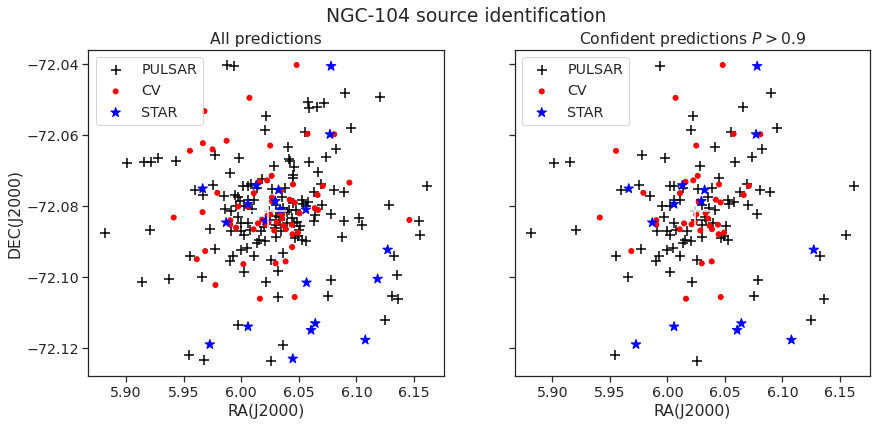

In [65]:
# Plot GC
#gca = gc_pred[gc_pred['gc']=='NGC-104']
sns.set(font_scale=1.3, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")

fig , ax = plt.subplots(nrows=1, ncols=2 , figsize=(14,6) , sharey=True) 
for c in gca['class'].unique():
    temp = gca[gca['class']==c].sort_values(by='class')
    rgba_colors = np.zeros((len(temp),3))
    # for red the first column needs to be one
    if(c=='CV'):
        rgba_colors[:,0] = 1
        marker='.'
    elif(c=='AGN'):
        rgba_colors[:,0] = 0.3
        rgba_colors[:,1] = 0.7
        rgba_colors[:,2] = 0.3
        marker='^'
    elif(c=='HMXB'):
        rgba_colors[:,0] = 1
        rgba_colors[:,1] = 1
        marker='s'
    elif(c=='STAR'):
        #rgba_colors[:,0] = 1
        rgba_colors[:,2] = 1
        marker = '*'
    elif(c=='PULSAR'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 0
        rgba_colors[:,2] = 0
        marker = '+'
    elif(c=='ULX'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 1
        rgba_colors[:,2] = 1
        marker = 'D'
    #rgba_colors[:, 3] = temp['prob']
    ax[0].scatter(temp['ra'] , temp['dec']  , label=c , marker=marker , s=100 , color = rgba_colors)
ax[0].legend()
g = gca[gca['prob']>0.9]
for c in g['class'].unique():
    temp = g[g['class']==c].sort_values(by='class')
    rgba_colors = np.zeros((len(temp),3))
    # for red the first column needs to be one
    if(c=='CV'):
        rgba_colors[:,0] = 1
        marker='.'
    elif(c=='AGN'):
        rgba_colors[:,0] = 0.3
        rgba_colors[:,1] = 0.7
        rgba_colors[:,2] = 0.3
        marker='^'
    elif(c=='HMXB'):
        rgba_colors[:,0] = 1
        rgba_colors[:,1] = 1
        marker='s'
    elif(c=='STAR'):
        #rgba_colors[:,0] = 1
        rgba_colors[:,2] = 1
        marker = '*'
    elif(c=='PULSAR'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 0
        rgba_colors[:,2] = 0
        marker = '+'
    elif(c=='ULX'):
        rgba_colors[:,0] = 0
        rgba_colors[:,1] = 1
        rgba_colors[:,2] = 1
        marker = 'D'
    #rgba_colors[:, 3] = temp['prob']
    ax[1].scatter(temp['ra'] , temp['dec']  , label=c , marker=marker , s=100 , color = rgba_colors)
    # the fourth column needs to be your alphas
ax[1].legend()
ax[0].set_title('All predictions')
ax[1].set_title('Confident predictions $P > 0.9$')
fig.suptitle('NGC-104 source identification')
ax[0].set_xlabel('RA(J2000)')
ax[1].set_xlabel('RA(J2000)')
ax[0].set_ylabel('DEC(J2000)')
center  = SkyCoord("00h24m05.67s"  , "-72d04m52.6s" , frame = 'fk5')
ax[0].scatter([center.ra.deg] , [center.dec.deg] , marker='+' , s=1500 , color='white')
ax[1].scatter([center.ra.deg] , [center.dec.deg] , marker='+' , s=1500 , color='white')
#plt.savefig('final_plots/ngc-104-pred.eps' , format='eps')
plt.show()

##### SED for AGN

In [19]:
sed = pd.read_csv('temp_files/agn-hgc-104.csv').drop_duplicates('Frequency')
sed

Frequency  Flux Density NED Uncertainty
0   9.190000e+17           NaN       <3.35E-11
4   5.560000e+17  2.120000e-09     +/-6.36E-10
8   3.770000e+17  4.910000e-10     +/-1.74E-10
12  2.220000e+17  4.370000e-10     +/-1.37E-10
16  9.670000e+16  8.790000e-09     +/-4.13E-09
20  8.940000e+13  7.340000e-05     +/-5.68E-06
23  6.510000e+13           NaN       <3.95E-04
26  2.590000e+13           NaN       <3.98E-04
29  1.360000e+13           NaN       <3.13E-03

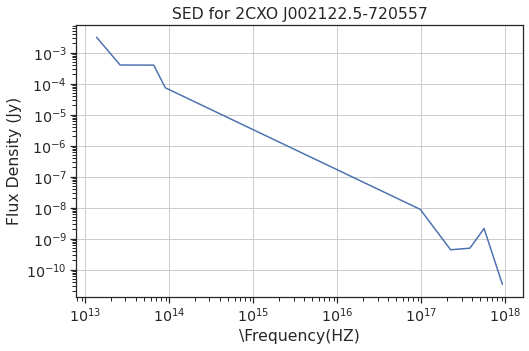

In [20]:
flux = [3.35E-11 ,2.120000e-09 , 4.910000e-10	 ,  4.370000e-10 , 8.790000e-09 , 7.340000e-05 , 3.95E-04 , 3.98E-04 , 3.13E-03	]
plt.figure(figsize=(8,5))
plt.loglog(sed['Frequency'] , flux)
plt.xlabel('\Frequency(HZ)')
plt.ylabel('Flux Density (Jy)')
plt.title('SED for 2CXO J002122.5-720557')
plt.grid()
plt.savefig('final_plots/agn-sed.eps' , format='eps')
plt.show()

In [21]:
gca[gca['prob_margin']<0.03]

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                       
2CXO J002224.3-715752    HMXB  0.403644     0.015498  0.388146  0.071404   
2CXO J002243.5-720939  PULSAR  0.410370     0.020552  0.003337  0.389818   
2CXO J002339.7-715846  PULSAR  0.492429     0.025113  0.001956  0.467317   
2CXO J002352.1-715601  PULSAR  0.491782     0.007313  0.002371  0.484469   
2CXO J002359.2-715843    HMXB  0.344810     0.020867  0.003495  0.323944   
2CXO J002408.5-720708  PULSAR  0.396774     0.007833  0.002958  0.388941   
2CXO J002422.0-721146      CV  0.457986     0.002226  0.001619  0.457986   
2CXO J002456.9-720810      CV  0.491402     0.017720  0.001033  0.491402   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J002224.3-715752   0.403644   0.000966     0.076034   0.007577  0.048929   
2CXO J002243.5-720939   0.168779   0.000517     0.410370   0.025543  0.000895   
2CXO J002339.7-715846   0.032923   0.000068     0.492429   0.003686  0.001452   
2CXO J002352.1-715601   0.017633   0.000039     0.491782   0.001781  0.001801   
2CXO J002359.2-715843   0.344810   0.000445     0.300993   0.022054  0.003867   
2CXO J002408.5-720708   0.098778   0.000597     0.396774   0.107769  0.003131   
2CXO J002422.0-721146   0.053042   0.000060     0.455760   0.006505  0.024905   
2CXO J002456.9-720810   0.031519   0.000083     0.473682   0.001614  0.000533   

                       prob_YSO       gc        ra        dec  significance  
name                                                                         
2CXO J002224.3-715752  0.003300  NGC-104  5.601639 -71.964661      5.485714  
2CXO J002243.5-720939  0.000742  NGC-104  5.681441 -72.160983      3.263158  
2CXO J002339.7-715846  0.000168  NGC-104  5.915697 -71.979674      3.687500  
2CXO J002352.1-715601  0.000125  NGC-104  5.967384 -71.933800      6.523275  
2CXO J002359.2-715843  0.000392  NGC-104  5.996899 -71.978820      3.812500  
2CXO J002408.5-720708  0.001050  NGC-104  6.035810 -72.119018      3.945946  
2CXO J002422.0-721146  0.000123  NGC-104  6.091817 -72.196315      3.729730  
2CXO J002456.9-720810  0.000132  NGC-104  6.237426 -72.136237      7.000152

In [22]:
gca[gca['class']=='HMXB']

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J002224.3-715752  HMXB  0.403644     0.015498  0.388146  0.071404   
2CXO J002336.2-721016  HMXB  0.678455     0.480458  0.005159  0.114193   
2CXO J002337.2-720854  HMXB  0.528545     0.146235  0.004087  0.382310   
2CXO J002353.3-721144  HMXB  0.383689     0.089986  0.293703  0.212493   
2CXO J002359.2-715843  HMXB  0.344810     0.020867  0.003495  0.323944   
2CXO J002522.1-721201  HMXB  0.563637     0.262871  0.015896  0.022753   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J002224.3-715752   0.403644   0.000966     0.076034   0.007577  0.048929   
2CXO J002336.2-721016   0.678455   0.000245     0.197997   0.002928  0.000659   
2CXO J002337.2-720854   0.528545   0.001260     0.049212   0.032661  0.001424   
2CXO J002353.3-721144   0.383689   0.001377     0.016048   0.022362  0.069143   
2CXO J002359.2-715843   0.344810   0.000445     0.300993   0.022054  0.003867   
2CXO J002522.1-721201   0.563637   0.000341     0.025087   0.071212  0.300765   

                       prob_YSO       gc        ra        dec  significance  
name                                                                         
2CXO J002224.3-715752  0.003300  NGC-104  5.601639 -71.964661      5.485714  
2CXO J002336.2-721016  0.000365  NGC-104  5.900900 -72.171387      4.606061  
2CXO J002337.2-720854  0.000500  NGC-104  5.905234 -72.148466      5.058824  
2CXO J002353.3-721144  0.001185  NGC-104  5.972248 -72.195772     15.385497  
2CXO J002359.2-715843  0.000392  NGC-104  5.996899 -71.978820      3.812500  
2CXO J002522.1-721201  0.000308  NGC-104  6.342294 -72.200403      4.812500

##### radial distribution

In [71]:
from utilities import get_true_data 
gca_true = get_true_data(gca[['r' , 'class' , 'prob' ,'prob_margin']])
gca_true = pd.merge(ui[['ra' , 'dec']] , gca_true , left_index =True , right_index = True , how = 'right')
gca_true

ra        dec           r   class      prob  \
name                                                                       
2CXO J002405.7-720452  6.023896 -72.081266    0.302568  PULSAR  0.999470   
2CXO J002406.0-720456  6.025117 -72.082283    3.977044      CV  0.995221   
2CXO J002405.4-720457  6.022810 -72.082582    4.782285      CV  0.585494   
2CXO J002407.2-720457  6.030138 -72.082654    8.751518  PULSAR  0.834013   
2CXO J002406.0-720501  6.025250 -72.083766    9.136855  PULSAR  0.999845   
...                         ...        ...         ...     ...       ...   
2CXO J002418.7-720225  6.077990 -72.040475  158.778745    STAR  0.999284   
2CXO J002331.4-720515  5.881189 -72.087654  159.397233  PULSAR  0.994531   
2CXO J002425.8-720703  6.107757 -72.117669  160.714616    STAR  0.981651   
2CXO J002352.2-720723  5.967776 -72.123257  163.268996  PULSAR  0.595037   
2CXO J002348.9-720719  5.954130 -72.122025  165.618473  PULSAR  0.974097   

                       prob_margin       gal_l      gal_b  var_flag  \
name                                                                  
2CXO J002405.7-720452     0.999072  305.894692 -44.889361         0   
2CXO J002406.0-720456     0.992794  305.893953 -44.888412         0   
2CXO J002405.4-720457     0.173708  305.894880 -44.888009         0   
2CXO J002407.2-720457     0.764099  305.891719 -44.888275         0   
2CXO J002406.0-720501     0.999704  305.893583 -44.886951         1   
...                            ...         ...        ...       ...   
2CXO J002418.7-720225     0.998709  305.880009 -44.932179         0   
2CXO J002331.4-720515     0.989545  305.954575 -44.876415         0   
2CXO J002425.8-720703     0.971382  305.851092 -44.857191         1   
2CXO J002352.2-720723     0.325645  305.909859 -44.845257         0   
2CXO J002348.9-720719     0.950656  305.915962 -44.845844         0   

                              b-csc  ...  bp-W3  rp-K  J-H  J-W1  W1-W2  u-g  \
name                                 ...                                       
2CXO J002405.7-720452  7.634460e-17  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002406.0-720456  2.679432e-14  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002405.4-720457  4.801502e-16  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002407.2-720457  2.299603e-15  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002406.0-720501  9.585383e-16  ...    NaN   NaN  NaN   NaN    NaN  NaN   
...                             ...  ...    ...   ...  ...   ...    ...  ...   
2CXO J002418.7-720225  0.000000e+00  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002331.4-720515  1.306584e-16  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002425.8-720703  4.660991e-15  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002352.2-720723  3.013127e-15  ...    NaN   NaN  NaN   NaN    NaN  NaN   
2CXO J002348.9-720719  4.962129e-16  ...    NaN   NaN  NaN   NaN    NaN  NaN   

                       g-r  r-z  i-z  u-z  
name                                       
2CXO J002405.7-720452  NaN  NaN  NaN  NaN  
2CXO J002406.0-720456  NaN  NaN  NaN  NaN  
2CXO J002405.4-720457  NaN  NaN  NaN  NaN  
2CXO J002407.2-720457  NaN  NaN  NaN  NaN  
2CXO J002406.0-720501  NaN  NaN  NaN  NaN  
...                    ...  ...  ...  ...  
2CXO J002418.7-720225  NaN  NaN  NaN  NaN  
2CXO J002331.4-720515  NaN  NaN  NaN  NaN  
2CXO J002425.8-720703  NaN  NaN  NaN  NaN  
2CXO J002352.2-720723  NaN  NaN  NaN  NaN  
2CXO J002348.9-720719  NaN  NaN  NaN  NaN  

[222 rows x 55 columns]

In [67]:
#import astropy.units as unit
from astropy.coordinates import SkyCoord

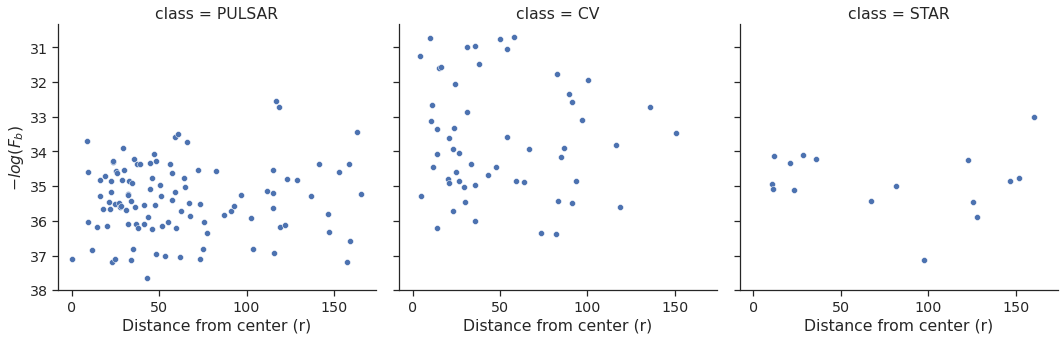

In [75]:
to_plot = gca_true[gca_true['class'].isin(['CV' , 'STAR' , 'PULSAR'])].reset_index(drop=True)
to_plot = to_plot[to_plot['b-csc']>0]
to_plot['b-csc-log'] = -np.log(to_plot['b-csc'])
g = sns.relplot(
    kind='scatter' , 
    data = to_plot ,
     y = 'b-csc-log' , x='r' ,
     col ='class' , 
     #bins=40 , 
     #cbar = True
    )
# to_plot = gca_true[gca_true['class']=='CV']
# plt.scatter(to_plot['r'] , -np.log(to_plot['b-csc']))
# to_plot = gca_true[gca_true['class']=='STAR']
# plt.scatter(to_plot['r'] , -np.log(to_plot['b-csc']))
plt.gca().invert_yaxis()
g.axes[0][0].set_ylabel('$-log(F_b)$')
for a in g.axes[0]:
    a.set_xlabel('Distance from center (r)')
#plt.savefig('final_plots/ngc-104-b-flux-dist.eps' , format='eps')
plt.show()

In [72]:
to_plot = gca_true[gca_true['class'].isin(['CV' , 'STAR' , 'PULSAR'])].reset_index(drop=True)
to_plot = to_plot[to_plot['b-csc']>0]
to_plot['b-csc-log'] = -np.log(to_plot['b-csc'])
print(len(to_plot))
r_bins = np.linspace(to_plot['r'].min(), to_plot['r'].max(), 8)
group = {}
from tqdm import tqdm
for cl in tqdm(['CV' , 'PULSAR' , 'STAR']):#
    group[cl] = []
    for i in range(len(r_bins)-1):
        to_plot = gca_true[gca_true['class']==cl].reset_index(drop=True)
        to_plot = to_plot[to_plot['b-csc']>0]
        to_plot['b-csc-log'] = -np.log(to_plot['b-csc'])
        temp = to_plot[to_plot['r']>=r_bins[i]]
        temp = temp[temp['r']<=r_bins[i+1]]
        group[cl].append(temp.describe()[['b-csc-log' ,'r']])
group['CV'][0]
r, mean , std , count = {} , {} , {} ,{}
for cl in ['PULSAR' , 'CV' , 'STAR']:
    r[cl] = []
    mean[cl] = []
    std[cl] = []
    count[cl] = []
    for g in group[cl]:
        r[cl].append(g['r']['mean'])
        mean[cl].append(g['b-csc-log']['mean'])
        std[cl].append(g['b-csc-log']['std'])
        count[cl].append(g['b-csc-log']['count'])
    count[cl] = np.asarray(count[cl])


179


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


In [73]:
group['CV'][0]

b-csc-log          r
count  17.000000  17.000000
mean   33.565421  15.110879
std     1.610648   6.137620
min    30.731257   3.977044
25%    32.655802  10.825195
50%    33.626004  13.980666
75%    34.803461  20.674306
max    36.213124  23.621635

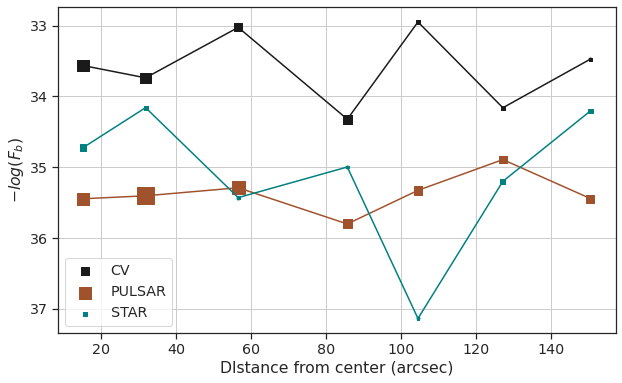

In [74]:
size = 8
plt.figure(figsize=(10,6))
plt.scatter(r['CV'] , mean['CV'] , s=size*count['CV'] , color='k' , marker='s' , label='CV')
plt.errorbar(r['CV'] , mean['CV']  , fmt='.-' , color='k')
plt.scatter(r['CV'] , mean['PULSAR'] , s=size*count['PULSAR'] , color='sienna' , marker='s' , label='PULSAR')
plt.errorbar(r['CV'] , mean['PULSAR']  , fmt='.-' , color='sienna')
plt.scatter(r['CV'] , mean['STAR'] , s=size*count['STAR'] , color='teal' , marker='s' , label='STAR')
plt.errorbar(r['CV'] , mean['STAR']  , fmt='.-' , color='teal')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('$-log(F_b)$')
plt.xlabel('DIstance from center (arcsec)')
#plt.savefig('final_plots/flux-radial-plot.eps' , format='eps')
plt.grid()
plt.show()

In [274]:
tuc_gaia = pd.read_csv('47tuc-gaia.csv')
tuc_gaia


angDist  ra_epoch2000  dec_epoch2000  errHalfMaj  errHalfMin  errPosAng  \
0    0.849916      6.023129     -72.081275    0.000219    0.000204     141.06   
1    1.960859      6.026624     -72.081997    0.067263    0.000346      36.74   
2    1.991025      6.025160     -72.084318    0.004418    0.004026      30.81   
3    2.655282      6.022997     -72.083514    0.019447    0.006581     125.79   
4    0.318924      6.029991     -72.079580    0.032954    0.021512      36.90   
..        ...           ...            ...         ...         ...        ...   
974  1.171769      5.343852     -72.099592    0.002090    0.002043     135.60   
975  0.960545      6.408898     -72.256655    0.016909    0.014692      62.65   
976  1.489512      6.355104     -72.275602    0.011532    0.009966      53.38   
977  1.885992      6.357956     -72.275819    0.004321    0.003691      86.94   
978  2.418337      6.357862     -72.276285    0.001181    0.001118      57.17   

               source_id        ra  ra_error        dec  ...      bp-R  g-J  \
0    4689639266848574080  6.023129    0.2099 -72.081275  ...  1.043109  NaN   
1    4689639266848627712  6.026624   40.2373 -72.081997  ...  1.056426  NaN   
2    4689639266845737344  6.025204    0.2230 -72.084338  ...  1.234237  NaN   
3    4689639266848575872  6.022997   16.2383 -72.083514  ...  1.234237  NaN   
4    4689639266844725888  6.029991   26.2195 -72.079580  ...  0.912328  NaN   
..                   ...       ...       ...        ...  ...       ...  ...   
974  4689618852849977984  5.343937    0.0973 -72.099603  ...       NaN  NaN   
975  4689575078559682304  6.408914    0.6885 -72.256661  ...       NaN  NaN   
976  4689574906765897728  6.355194    0.5425 -72.275605  ...       NaN  NaN   
977  4689574906765868032  6.358036    0.2000 -72.275832  ...       NaN  NaN   
978  4689574911038792832  6.357912    0.0558 -72.276290  ...       NaN  NaN   

     g-W2  bp-H  bp-W3  rp-K  J-H  J-W1  W1-W2           r  
0     NaN   NaN    NaN   NaN  NaN   NaN    NaN    0.302568  
1     NaN   NaN    NaN   NaN  NaN   NaN    NaN    3.977044  
2     NaN   NaN    NaN   NaN  NaN   NaN    NaN    9.136855  
3     NaN   NaN    NaN   NaN  NaN   NaN    NaN    9.136855  
4     NaN   NaN    NaN   NaN  NaN   NaN    NaN    9.547329  
..    ...   ...    ...   ...  ...   ...    ...         ...  
974   NaN   NaN    NaN   NaN  NaN   NaN    NaN  755.015657  
975   NaN   NaN    NaN   NaN  NaN   NaN    NaN  760.014819  
976   NaN   NaN    NaN   NaN  NaN   NaN    NaN  790.467922  
977   NaN   NaN    NaN   NaN  NaN   NaN    NaN  790.467922  
978   NaN   NaN    NaN   NaN  NaN   NaN    NaN  790.467922  

[979 rows x 110 columns]

In [ ]:
tuc_gaia = tuc_gaia[['angDist' , 'source_id', 'phot_g_mean_mag_corrected', 'phot_g_mean_mag','phot_bp_mean_mag' , 'phot_rp_mean_mag' , 'name']]
tuc_gaia = tuc_gaia.drop_duplicates('name').drop_duplicates('source_id').set_index('name')
tuc_gaia = tuc_gaia.dropna(how='any')

In [262]:
tuc_gaia[tuc_gaia['angDist']<1]

angDist            source_id  \
name                                                   
2CXO J002405.7-720452  0.849916  4689639266848574080   
2CXO J002407.2-720446  0.318924  4689639266844725888   
2CXO J002405.0-720502  0.958604  4689639266844757632   
2CXO J002407.7-720431  0.207651  4689639473007355520   
2CXO J002408.3-720431  0.669712  4689639473007324032   
...                         ...                  ...   
2CXO J002243.5-720939  0.875423  4689637205260969472   
2CXO J002405.5-715640  0.809563  4689644725765143808   
2CXO J002549.9-720220  0.862905  4689633764982939648   
2CXO J002435.3-721444  0.963483  4689621915173727104   
2CXO J002537.9-721523  0.960545  4689575078559682304   

                       phot_g_mean_mag_corrected  phot_g_mean_mag  \
name                                                                
2CXO J002405.7-720452                  13.137397        13.137397   
2CXO J002407.2-720446                  13.793488        13.793488   
2CXO J002405.0-720502                  11.460905        11.460905   
2CXO J002407.7-720431                  10.986235        10.986235   
2CXO J002408.3-720431                  10.930183        10.930183   
...                                          ...              ...   
2CXO J002243.5-720939                  19.944493        19.941600   
2CXO J002405.5-715640                  20.795533        20.792126   
2CXO J002549.9-720220                  18.049297        18.049297   
2CXO J002435.3-721444                  11.508721        11.508721   
2CXO J002537.9-721523                  20.602602        20.602602   

                       phot_bp_mean_mag  phot_rp_mean_mag  
name                                                       
2CXO J002405.7-720452         12.238500         11.195391  
2CXO J002407.2-720446         12.614349         11.702021  
2CXO J002405.0-720502         11.470914         10.089309  
2CXO J002407.7-720431         12.359630          9.653745  
2CXO J002408.3-720431         11.640931          9.755794  
...                                 ...               ...  
2CXO J002243.5-720939         19.959888         18.867530  
2CXO J002405.5-715640         21.437498         20.443440  
2CXO J002549.9-720220         18.353292         17.519920  
2CXO J002435.3-721444         11.885652         10.964990  
2CXO J002537.9-721523         20.770535         19.895725  

[75 rows x 6 columns]

In [263]:
gc_true_gaia = pd.merge(gca , tuc_gaia , left_index =True, right_index =True , how = 'left')
gc_true_gaia = pd.merge(gc_true_gaia , gca_true[['ra' , 'dec' , 'r']] , left_index =True , right_index =True)
gc_true_gaia = gc_true_gaia.sort_values(by='r')

In [264]:
gc_true_gaia.columns.to_list()

['class',
 'prob',
 'prob_margin',
 'prob_AGN',
 'prob_CV',
 'prob_HMXB',
 'prob_LMXB',
 'prob_PULSAR',
 'prob_STAR',
 'prob_ULX',
 'prob_YSO',
 'gc',
 'ra_x',
 'dec_x',
 'significance',
 'angDist',
 'source_id',
 'phot_g_mean_mag_corrected',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'ra_y',
 'dec_y',
 'r']

In [265]:

to_plot = gc_true_gaia[gc_true_gaia['class'].isin(['CV' , 'STAR' , 'PULSAR'])].reset_index(drop=True)
#to_plot = to_plot[to_plot['b-csc']>0]
#to_plot['phot_g_mean_mag_corrected'] = -np.log(to_plot['b-csc'])
print(len(to_plot))
r_bins = np.linspace(to_plot['r'].min(), to_plot['r'].max(), 8)
group = {}
from tqdm import tqdm
for cl in tqdm(['CV' , 'PULSAR' , 'STAR']):#
    group[cl] = []
    for i in range(len(r_bins)-1):
        to_plot = gc_true_gaia[gc_true_gaia['class']==cl].reset_index(drop=True)
        #to_plot = to_plot[to_plot['b-csc']>0]
        #to_plot['phot_g_mean_mag_corrected'] = -np.log(to_plot['b-csc'])
        temp = to_plot[to_plot['r']>=r_bins[i]]
        temp = temp[temp['r']<=r_bins[i+1]]
        group[cl].append(temp.describe()[['phot_g_mean_mag_corrected' ,'r']])
group['CV'][0]
r, mean , std , count = {} , {} , {} ,{}
for cl in ['PULSAR' , 'CV' , 'STAR']:
    r[cl] = []
    mean[cl] = []
    std[cl] = []
    count[cl] = []
    for g in group[cl]:
        r[cl].append(g['r']['mean'])
        mean[cl].append(g['phot_g_mean_mag_corrected']['mean'])
        std[cl].append(g['phot_g_mean_mag_corrected']['std'])
        count[cl].append(g['phot_g_mean_mag_corrected']['count'])
    count[cl] = np.asarray(count[cl])


356


100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


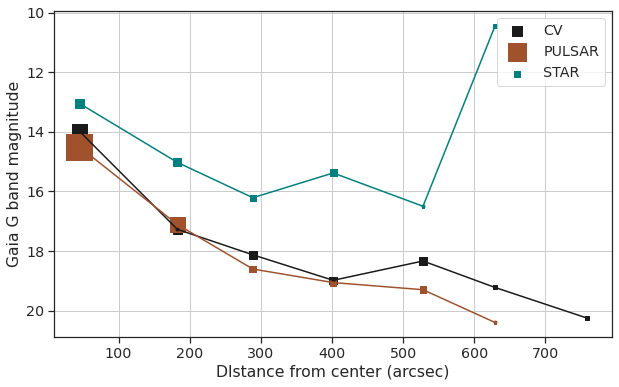

In [269]:
size = 8
plt.figure(figsize=(10,6))
plt.scatter(r['CV'] , mean['CV'] , s=size*count['CV'] , color='k' , marker='s' , label='CV')
plt.errorbar(r['CV'] , mean['CV']  , fmt='.-' , color='k')
plt.scatter(r['CV'] , mean['PULSAR'] , s=size*count['PULSAR'] , color='sienna' , marker='s' , label='PULSAR')
plt.errorbar(r['CV'] , mean['PULSAR']  , fmt='.-' , color='sienna')
plt.scatter(r['CV'] , mean['STAR'] , s=size*count['STAR'] , color='teal' , marker='s' , label='STAR')
plt.errorbar(r['CV'] , mean['STAR']  , fmt='.-' , color='teal')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Gaia G band magnitude')
plt.xlabel('DIstance from center (arcsec)')
plt.savefig('final_plots/gaia-g-mag-ngc-104.eps' , format='eps')
plt.grid()
plt.show()

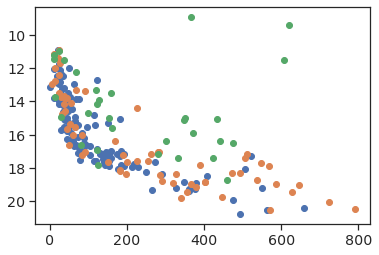

In [259]:
to_plot = gc_true_gaia[gc_true_gaia['class']=='PULSAR']
plt.scatter(to_plot['r'] , to_plot['phot_g_mean_mag_corrected'])
to_plot = gc_true_gaia[gc_true_gaia['class']=='CV']
plt.scatter(to_plot['r'] , to_plot['phot_g_mean_mag_corrected'])
to_plot = gc_true_gaia[gc_true_gaia['class']=='STAR']
plt.scatter(to_plot['r'] , to_plot['phot_g_mean_mag_corrected'])
plt.gca().invert_yaxis()
plt.show()

/home/kumaran/.local/lib/python3.6/site-packages/binsreg/binsregselect.py:336: UserWarning: too small effective sample size for DPI selection.
/home/kumaran/.local/lib/python3.6/site-packages/binsreg/binsreg.py:595: UserWarning: DPI selection fails. ROT choice used.
/home/kumaran/.local/lib/python3.6/site-packages/binsreg/binsreg.py:706: UserWarning: too small effective sample size for dots. # of mass points or clusters used.
/home/kumaran/.local/lib/python3.6/site-packages/binsreg/binsreg.py:714: UserWarning: too small effective sample size for ci.
/home/kumaran/.local/lib/python3.6/site-packages/binsreg/binsreg.py:798: UserWarning: dots=c(0,0) used.


ValueError: object too deep for desired array

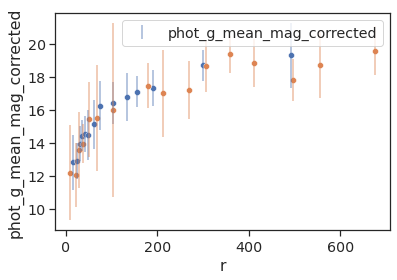

In [117]:
# Plot binned scatterplot
df_est = binscatter(x='r', y='phot_g_mean_mag_corrected', data=gc_true_gaia[gc_true_gaia['class']=='PULSAR'], ci=(3,3))
df_est.head()
sns.scatterplot(x='r', y='phot_g_mean_mag_corrected', data=df_est);
plt.errorbar('r', 'phot_g_mean_mag_corrected', yerr='ci', data=df_est, ls='', lw=2, alpha=0.4);
# Plot binned scatterplot
df_est = binscatter(x='r', y='phot_g_mean_mag_corrected', data=gc_true_gaia[gc_true_gaia['class']=='CV'], ci=(3,3))
df_est.head()
sns.scatterplot(x='r', y='phot_g_mean_mag_corrected', data=df_est);
plt.errorbar('r', 'phot_g_mean_mag_corrected', yerr='ci', data=df_est, ls='', lw=2, alpha=0.4);

df_est = binscatter(x='r', y='phot_g_mean_mag_corrected', data=gc_true_gaia[gc_true_gaia['class']=='STAR'], ci=(3,3))
df_est.head()
sns.scatterplot(x='r', y='phot_g_mean_mag_corrected', data=df_est);
plt.errorbar('r', 'phot_g_mean_mag_corrected', yerr='ci', data=df_est, ls='', lw=2, alpha=0.4);

plt.title("Sales by firm's age");
plt.gca().invert_yaxis()

In [115]:
# Plot binned scatterplot
gca_true['b-csc-log'] = -np.log(gca_true['b-csc'])
df_est = binscatter(x='r', y='b-csc-log', data=gca_true[gca_true['class']=='PULSAR'], ci=(3,3))
df_est.head()
sns.scatterplot(x='r', y='b-csc-log', data=df_est);
plt.errorbar('r', 'b-csc-log', yerr='ci', data=df_est, ls='', lw=2, alpha=0.4);
# Plot binned scatterplot
df_est = binscatter(x='r', y='b-csc-log', data=gca_true[gca_true['class']=='CV'], ci=(3,3))
df_est.head()
sns.scatterplot(x='r', y='b-csc-log', data=df_est);
plt.errorbar('r', 'b-csc-log', yerr='ci', data=df_est, ls='', lw=2, alpha=0.4);

plt.title("Sales by firm's age");
plt.gca().invert_yaxis()
plt.yscale('log')
plt.show()

Exception: bin selection fails.

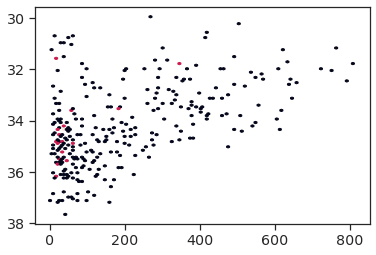

In [134]:
plt.hexbin(gca_true['r'] , gca_true['b-csc-log'] , mincnt=1)
plt.gca().invert_yaxis()
plt.show()

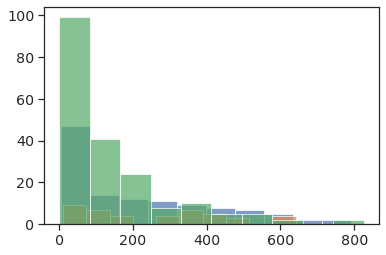

#### Check similarity between the paper and our result

In [80]:
comp = pd.read_csv('NGC-104/gc-sources-cross-match.csv')[['Identifier' , 'name' ,'Otype'   , 'class' , 'prob' , 'prob_margin']]
obj = ['CV*' , 'PM*' , 'Psr' ,]
#obj = ['X']
#comp = comp[comp['Otype'].isin(obj)].sort_values(by=['Otype' ,'prob',  'class'] , ascending=False).reset_index(drop=True)
obj = ['STAR']
comp = comp[comp['class'].isin(obj)].sort_values(by=['Otype' ,'prob',  'class'] , ascending=False).reset_index(drop=True)


In [81]:
comp

Identifier                   name Otype class      prob  \
0   CXOGlb J002405.1-720502  2CXO J002405.0-720502   XB?  STAR  0.818940   
1   CXOGlb J002413.4-720451  2CXO J002413.4-720451   XB?  STAR  0.810578   
2   CXOGlb J002351.9-720429  2CXO J002351.9-720430     X  STAR  0.999904   
3            [GHE2001] W201  2CXO J002407.0-720442     X  STAR  0.998913   
4   CXOGlb J002401.2-720650  2CXO J002401.3-720650     X  STAR  0.997623   
5   CXOGlb J002401.3-720445  2CXO J002401.3-720445     X  STAR  0.997374   
6   CXOGlb J002356.8-720504  2CXO J002356.8-720504     X  STAR  0.994483   
7   CXOGlb J002353.3-720707  2CXO J002353.4-720708     X  STAR  0.993828   
8   CXOGlb J002415.4-720646  2CXO J002415.4-720646     X  STAR  0.993819   
9   CXOGlb J002414.5-720653  2CXO J002414.5-720653     X  STAR  0.989417   
10  CXOGlb J002430.6-720532  2CXO J002430.5-720532     X  STAR  0.948937   
11  CXOGlb J002403.0-720426  2CXO J002403.1-720426     X  STAR  0.933317   
12  CXOGlb J002428.3-720601  2CXO J002428.4-720601     X  STAR  0.595172   
13           [GHE2001] W197  2CXO J002408.1-720451     X  STAR  0.569069   
14           [GHE2001] W227  2CXO J002418.7-720225   PM*  STAR  0.999284   

    prob_margin  
0      0.638308  
1      0.702282  
2      0.999865  
3      0.998097  
4      0.995642  
5      0.994762  
6      0.989785  
7      0.990685  
8      0.989027  
9      0.979499  
10     0.900647  
11     0.872363  
12     0.243507  
13     0.154759  
14     0.998709

In [82]:
print(comp.to_latex(float_format='%.2f' , index = False , ))

\begin{tabular}{llllrr}
\toprule
              Identifier &                   name & Otype & class &  prob &  prob\_margin \\
\midrule
 CXOGlb J002405.1-720502 &  2CXO J002405.0-720502 &   XB? &  STAR &  0.82 &         0.64 \\
 CXOGlb J002413.4-720451 &  2CXO J002413.4-720451 &   XB? &  STAR &  0.81 &         0.70 \\
 CXOGlb J002351.9-720429 &  2CXO J002351.9-720430 &     X &  STAR &  1.00 &         1.00 \\
          [GHE2001] W201 &  2CXO J002407.0-720442 &     X &  STAR &  1.00 &         1.00 \\
 CXOGlb J002401.2-720650 &  2CXO J002401.3-720650 &     X &  STAR &  1.00 &         1.00 \\
 CXOGlb J002401.3-720445 &  2CXO J002401.3-720445 &     X &  STAR &  1.00 &         0.99 \\
 CXOGlb J002356.8-720504 &  2CXO J002356.8-720504 &     X &  STAR &  0.99 &         0.99 \\
 CXOGlb J002353.3-720707 &  2CXO J002353.4-720708 &     X &  STAR &  0.99 &         0.99 \\
 CXOGlb J002415.4-720646 &  2CXO J002415.4-720646 &     X &  STAR &  0.99 &         0.99 \\
 CXOGlb J002414.5-720653 &  2CXO J002

In [282]:
clf.feature_importances_


array([3180, 2910,  760, 1029, 1290,   82, 1099,   51, 1622,  845, 1405,
       1197, 1259, 1506,   86,  144,   95,  145,   64,   49,   54,  154,
         49,  107,  227,  565,  293,  249,  393,  491,  307,  370,  621,
        172,   74,   98,   69,  144,  359,  153,  233], dtype=int32)

In [281]:
clf.feature_name_

['gal_b2',
 'gal_l2',
 'var_inter_prob_b',
 'var_inter_sigma_b',
 'var_intra_prob_b',
 'var_inter_index_b',
 'kp_intra_prob_b',
 'var_intra_index_b',
 'h-csc',
 'b-csc',
 'm-csc',
 's-csc',
 'u-csc',
 '0p3_8_csc',
 'FUV',
 'NUV',
 'u-sdss',
 'g-sdss',
 'r-sdss',
 'i-sdss',
 'z-sdss',
 'W1',
 'W2',
 'W3',
 'W4',
 '24_microns_(MIPS)',
 'J',
 'H',
 'K',
 'G',
 'Bp',
 'Rp',
 'B-R',
 'G-J',
 'G-W2',
 'Bp-H',
 'Bp-W3',
 'Rp-K',
 'J-H',
 'J-W1',
 'W1-W2']

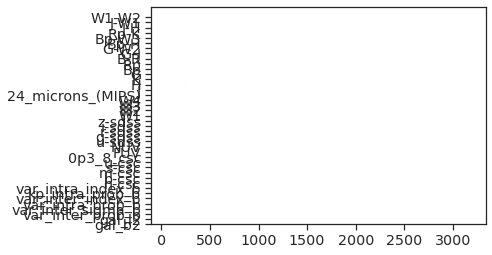

In [286]:
plt.bar(clf.feature_importances_ , clf.feature_name_ , color='k')
plt.show()

In [333]:
feat_imp = pd.DataFrame({
    'name' : clf.feature_name_ , 
    'imp' : (clf.feature_importances_) / np.amax(clf.feature_importances_)
}).sort_values(by = 'imp' , ascending=False)#.drop('24_microns_(MIPS)')

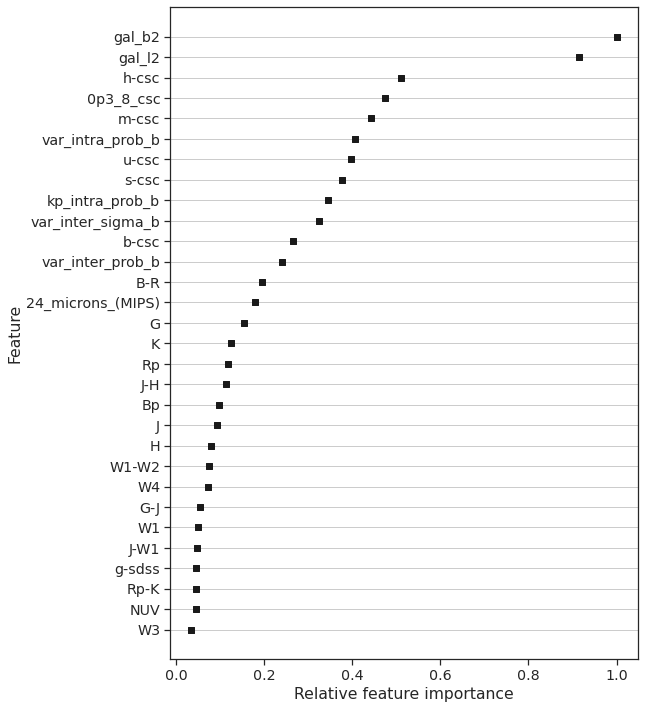

In [353]:
plt.figure(figsize=(10,12))
top_feat = 30
plt.scatter( feat_imp['imp'][:top_feat], feat_imp['name'][:top_feat] , marker='s' , s=40 , color='k')
ax = plt.gca()
ax.invert_yaxis()
ax.yaxis.grid()
plt.gcf().subplots_adjust(left=0.25)
plt.xlabel('Relative feature importance')
plt.ylabel('Feature')
plt.savefig('final_plots/feat_imp.eps' , format='eps')
plt.show()